## Statistics Generated Summaries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# sns.set_color_codes()
# sns.set_theme()
sns.set_context("paper")

In [3]:
from pprint import pprint
from pathlib import Path
import re
import pandas as pd
import json
from tqdm.auto import tqdm
from multiprocessing import Pool
import numpy as np
import itertools

from info_salience import utils


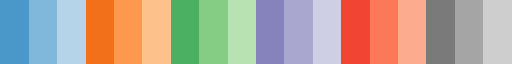

In [4]:
import matplotlib

N = 3
base_cmaps = ['Blues', 'Oranges', 'Greens', 'Purples','Reds', 'Greys']

n_base = len(base_cmaps)
# we go from 0.3 to 0.7 below to avoid having several whites and blacks in the resulting cmaps
colors = np.concatenate([plt.get_cmap(name)(sorted(np.linspace(0.3,0.6,N), reverse=True)) for name in base_cmaps])
cmap = matplotlib.colors.ListedColormap(colors)
cmap

In [5]:
########################
# Model colors
########################
MODEL_MAP = {
    "greedy": "Greedy",
    "random": "Random",
    "lead_1": "Lead 1",
    "lead_n": "Lead N",
    "textrank": "TextRank",

    "OLMo-7B-Instruct-hf": "OLMo (7B)",
    "OLMo-7B-0724-Instruct-hf": "OLMo 0724 (7B)",

    "Mistral-7B-Instruct-v0.3": "Mistral (7B)",
    "Mixtral-8x7B-Instruct-v0.1": "Mixtral (8x7B)",

    "Llama-2-7b-chat-hf": "Llama 2 (7B)",
    "Llama-2-13b-chat-hf": "Llama 2 (13B)",
    "Llama-2-70b-chat-hf": "Llama 2 (70B)",

    "Meta-Llama-3-8B-Instruct": "Llama 3 (8B)",
    "Meta-Llama-3-70B-Instruct": "Llama 3 (70B)",

    "Meta-Llama-3.1-8B-Instruct": "Llama 3.1 (8B)",
    "Meta-Llama-3.1-70B-Instruct": "Llama 3.1 (70B)",

    "Meta-Llama-3.1-8B-Instruct-quantized.w8a8": "Llama 3.1 (8B_Q8)",
    "Meta-Llama-3.1-70B-Instruct-quantized.w8a8": "Llama 3.1 (70B_Q8)",

    "gpt-4o-mini-2024-07-18": "GPT-4o-mini (07/24)",
    "gpt-4o-2024-08-06": "GPT-4o (08/24)",    
}


def model_ids_to_display_name(model_ids):
    return [MODEL_MAP[model_id] for model_id in model_ids]


def model_ids_to_display_order(model_ids):
    model_ids = set(model_ids)
    assert all((model_id in MODEL_MAP for model_id in model_ids))
    return [v for k, v in MODEL_MAP.items() if k in model_ids]


########################
# Model colors
########################

COLOR_MAP = {
    # blue
    'Meta-Llama-3.1-8B-Instruct': cmap(0),
    'Meta-Llama-3.1-70B-Instruct': cmap(1),

    # orange
    'Meta-Llama-3-8B-Instruct': cmap(3),
    'Meta-Llama-3-70B-Instruct': cmap(4),

    # greens
    'Llama-2-7b-chat-hf': cmap(6),
    'Llama-2-13b-chat-hf': cmap(7),
    'Llama-2-70b-chat-hf': cmap(8),
    
    # purples
    'gpt-4o-mini-2024-07-18': cmap(9),
    'gpt-4o-2024-08-06': cmap(10),

    # reds
    'Mistral-7B-Instruct-v0.3': cmap(12),
    'Mixtral-8x7B-Instruct-v0.1': cmap(13),
       
    # grays
    'OLMo-7B-Instruct-hf': cmap(15),
    'OLMo-7B-0724-Instruct-hf': cmap(16),
}

rename_dataset = {
    'pubmed-sample': 'RCT',
    'astro-ph': 'Astro',
    'cs-cl': 'CL',
    'qmsum-generic': 'QMSum'
}


def model_ids_to_display_color(model_ids):
    model_ids = set(model_ids)
    return {MODEL_MAP[model_id]: COLOR_MAP[model_id] for model_id in model_ids}

## Apply to all summaries

In [6]:
def load_summaries(json_path):
    df = pd.read_json(json_path)
    df = df.melt(var_name="length_target", value_name="summary", id_vars=["doc_id", "text"])
    df = df[["doc_id", "text", "summary", "length_target"]]
    df["summary"] = df["summary"].fillna("")

    # drop obsolete experiments with expand prompts
    df = df[~df["length_target"].apply(lambda x: "summary_e" in x)].copy()

    # calculate stats
    try:
        df["length_target"] = (
            df["length_target"].str.extract(r"summary_(\d+)")[0].astype(int)
        )
    except ValueError:
        print(json_path)
        raise

    df["length_actual"] = df["summary"].str.split().apply(len)

    json_path = Path(json_path)
    if "output" in json_path.name:
        # for random, lead, textrank baselines
        match = re.match("output-(\d+).json", str(json_path))
        df["repetition"] = match.group(1) if match else 0
        df["temperature"] = -1
    else:
        match = re.match(".*temperature([\d\.]+)-(\d+).json", str(json_path))
        df["temperature"] = float(match.group(1))
        df["repetition"] = int(match.group(2))

    df["model"] = json_path.parent.parent.name
    df = df.drop(["text", "summary"], axis=1)
    return df

In [7]:
def load_all_summaries(dataset):
    all_paths = list(Path(f"../output/{dataset}/").glob("**/summaries/*.json"))

    with Pool(8) as p:
        all_dfs = list(tqdm(p.imap(load_summaries, all_paths), total=len(all_paths)))

    df = pd.concat(all_dfs)
    df['dataset'] = dataset

    # Report some usage statistics
    print('='*30, dataset, '='*30)
    mem_usage = df.memory_usage(deep=True) / 1024 / 1024
    print(f"Memory usage: {mem_usage.sum():.1f} MB")
    print(f"Rows: {len(df)}")
    print(df["model"].value_counts())

    return df

In [8]:
stats = {
    dataset: load_all_summaries(dataset)
    for dataset in ['pubmed-sample', 'cs-cl', 'astro-ph', 'qmsum-generic']
}

  0%|          | 0/1128 [00:00<?, ?it/s]

============================== pubmed-sample ==============================
Memory usage: 212.7 MB
Rows: 1128000
model
Meta-Llama-3.1-70B-Instruct    101000
Llama-2-7b-chat-hf             101000
OLMo-7B-0724-Instruct-hf       101000
Meta-Llama-3-8B-Instruct       101000
Llama-2-13b-chat-hf            101000
Meta-Llama-3-70B-Instruct      101000
Mistral-7B-Instruct-v0.3       101000
Meta-Llama-3.1-8B-Instruct     101000
Mixtral-8x7B-Instruct-v0.1     101000
Llama-2-70b-chat-hf            101000
OLMo-7B-Instruct-hf            101000
gpt-4o-2024-08-06                5000
gpt-4o-mini-2024-07-18           5000
random                           3000
greedy                           1000
lead_1                           1000
textrank                         1000
lead_n                           1000
Name: count, dtype: int64


  0%|          | 0/74 [00:00<?, ?it/s]

============================== cs-cl ==============================
Memory usage: 16.2 MB
Rows: 68450
model
Meta-Llama-3-8B-Instruct       4625
Meta-Llama-3.1-70B-Instruct    4625
Llama-2-70b-chat-hf            4625
Mixtral-8x7B-Instruct-v0.1     4625
Mistral-7B-Instruct-v0.3       4625
Meta-Llama-3.1-8B-Instruct     4625
OLMo-7B-0724-Instruct-hf       4625
gpt-4o-2024-08-06              4625
random                         4625
OLMo-7B-Instruct-hf            4625
Llama-2-13b-chat-hf            4625
Llama-2-7b-chat-hf             4625
Meta-Llama-3-70B-Instruct      4625
gpt-4o-mini-2024-07-18         4625
greedy                          925
lead_n                          925
textrank                        925
lead_1                          925
Name: count, dtype: int64


  0%|          | 0/74 [00:00<?, ?it/s]

============================== astro-ph ==============================
Memory usage: 9.4 MB
Rows: 39220
model
Mistral-7B-Instruct-v0.3       2650
gpt-4o-mini-2024-07-18         2650
Meta-Llama-3-70B-Instruct      2650
Meta-Llama-3-8B-Instruct       2650
gpt-4o-2024-08-06              2650
Llama-2-70b-chat-hf            2650
OLMo-7B-Instruct-hf            2650
random                         2650
Llama-2-13b-chat-hf            2650
Llama-2-7b-chat-hf             2650
Meta-Llama-3.1-8B-Instruct     2650
Mixtral-8x7B-Instruct-v0.1     2650
Meta-Llama-3.1-70B-Instruct    2650
OLMo-7B-0724-Instruct-hf       2650
lead_1                          530
greedy                          530
textrank                        530
lead_n                          530
Name: count, dtype: int64


  0%|          | 0/423 [00:00<?, ?it/s]

============================== qmsum-generic ==============================
Memory usage: 48.8 MB
Rows: 190350
model
Meta-Llama-3.1-8B-Instruct                    45450
Mistral-7B-Instruct-v0.3                      45450
Meta-Llama-3.1-8B-Instruct-quantized.w8a8     45450
Mixtral-8x7B-Instruct-v0.1                    43200
random                                         2250
Meta-Llama-3.1-70B-Instruct-quantized.w8a8     2250
gpt-4o-mini-2024-07-18                         2250
Meta-Llama-3.1-70B-Instruct                    2250
greedy                                          450
lead_1                                          450
lead_n                                          450
textrank                                        450
Name: count, dtype: int64


In [9]:
def parsing_problems(df):
    df = df.copy()
    df["is_zero"] = df["length_actual"] == 0
    grouped = (
        df.groupby(["model", "temperature"])
        .agg(zero_percentage=("is_zero", "mean"))
        .reset_index()
    )
    
    pivot_table = grouped.pivot_table(
        index=["model"],
        columns="temperature",
        values="zero_percentage",
        fill_value=np.nan,
        observed=True,
    )
    
    ordered = [m for m in MODEL_MAP.keys() if m in pivot_table.index]
    pivot_table = pivot_table.loc[ordered]
    
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        pivot_table.columns = [f"{col:.2f}" for col in pivot_table.columns]
        styled = pivot_table.style.format("{:.3f}").background_gradient(cmap="Blues")
        display(styled)    

In [10]:
for dataset, df in stats.items():
    print('='*80)
    print(dataset)
    print('='*80)
    parsing_problems(df)

pubmed-sample


cs-cl


astro-ph


qmsum-generic


In [11]:
df_raw = pd.concat(df for df in stats.values())

In [12]:

df_stats = df_raw[(df_raw['temperature'] == -1) | (df_raw['temperature'] == 0.3)].groupby(['dataset', 'model', 'length_target'])['length_actual'].mean().unstack(level=2).round(1)

with pd.option_context('display.max_rows', None):
    display(df_stats)


length_target                                              10    20     50   \
dataset       model                                                           
astro-ph      Llama-2-13b-chat-hf                          9.7  23.1   49.5   
              Llama-2-70b-chat-hf                          8.0  16.8   56.7   
              Llama-2-7b-chat-hf                          10.6  25.6   62.7   
              Meta-Llama-3-70B-Instruct                    9.0  15.7   39.3   
              Meta-Llama-3-8B-Instruct                     8.4  17.0   43.1   
              Meta-Llama-3.1-70B-Instruct                  9.0  15.6   44.1   
              Meta-Llama-3.1-8B-Instruct                   9.7  16.8   42.4   
              Mistral-7B-Instruct-v0.3                    19.2  26.8   49.7   
              Mixtral-8x7B-Instruct-v0.1                   8.9  16.6   52.6   
              OLMo-7B-0724-Instruct-hf                    16.0  33.1  101.6   
              OLMo-7B-Instruct-hf                         24.9  40.3   79.3   
              gpt-4o-2024-08-06                            8.3  16.2   45.8   
              gpt-4o-mini-2024-07-18                       8.4  16.9   45.0   
              greedy                                       6.1  13.2   36.2   
              lead_1                                      26.6  26.6   26.6   
              lead_n                                      26.6  27.0   42.1   
              random                                      22.6  23.4   39.9   
              textrank                                    37.4  37.4   43.0   
cs-cl         Llama-2-13b-chat-hf                         10.8  25.3   44.2   
              Llama-2-70b-chat-hf                          7.4  17.6   45.8   
              Llama-2-7b-chat-hf                          11.6  25.9   51.3   
              Meta-Llama-3-70B-Instruct                    8.8  15.9   37.7   
              Meta-Llama-3-8B-Instruct                     8.3  17.3   41.9   
              Meta-Llama-3.1-70B-Instruct                  8.9  15.4   43.0   
              Meta-Llama-3.1-8B-Instruct                   9.6  17.0   43.0   
              Mistral-7B-Instruct-v0.3                    19.1  28.0   48.9   
              Mixtral-8x7B-Instruct-v0.1                   7.6  15.2   47.2   
              OLMo-7B-0724-Instruct-hf                    13.9  28.2   69.8   
              OLMo-7B-Instruct-hf                         17.1  25.0   44.0   
              gpt-4o-2024-08-06                            8.1  15.4   44.9   
              gpt-4o-mini-2024-07-18                       8.3  16.7   44.2   
              greedy                                       5.0  11.4   32.1   
              lead_1                                      19.3  19.3   19.3   
              lead_n                                      19.3  21.6   40.6   
              random                                      15.1  18.5   39.5   
              textrank                                    22.8  23.7   40.4   
pubmed-sample Llama-2-13b-chat-hf                         10.7  19.0   33.6   
              Llama-2-70b-chat-hf                          8.6  14.6   36.0   
              Llama-2-7b-chat-hf                           9.0  15.7   35.1   
              Meta-Llama-3-70B-Instruct                    9.2  16.0   38.4   
              Meta-Llama-3-8B-Instruct                     8.7  16.7   40.3   
              Meta-Llama-3.1-70B-Instruct                  9.2  16.0   43.9   
              Meta-Llama-3.1-8B-Instruct                   9.6  17.1   42.6   
              Mistral-7B-Instruct-v0.3                    16.5  22.7   40.9   
              Mixtral-8x7B-Instruct-v0.1                   9.3  14.3   40.4   
              OLMo-7B-0724-Instruct-hf                    13.8  28.7   88.5   
              OLMo-7B-Instruct-hf                         24.6  33.1   53.0   
              gpt-4o-2024-08-06                            8.3  15.9   45.1   
              gpt-4o-mini-2024-07-18              

## Analysis 1: how well do models meet the length target?

In [13]:
def is_outlier(s):
    # https://stackoverflow.com/a/46740476/3423035
    low = s.quantile(0.01)
    high = s.quantile(0.99)
    mask = ~s.between(low, high)
    # print(f'{s.name}: [{low:.2f}, {high:.2f}] | outliers: {sum(mask)/len(s)*100:.1f}%')
    return mask

In [14]:
exclude_models = [
    "Meta-Llama-3.1-8B-Instruct-quantized.w8a8",
    "Meta-Llama-3.1-70B-Instruct-quantized.w8a8"
]

df = df_raw[
    (df_raw['length_actual'] > 0)
    & ~df_raw['model'].isin(exclude_models)
    & (df_raw['temperature'] == 0.3)
]
df = df.reset_index().copy()

df['deviation'] = df['length_actual'] / df['length_target']
df['outlier'] = df.groupby(['dataset', 'model', 'length_target'])['deviation'].transform(is_outlier)

order = model_ids_to_display_order(df['model'])
color = model_ids_to_display_color(df['model'])
df['model'] = model_ids_to_display_name(df['model'])

print(len(df))

170535


Summaries by model and dataset

In [15]:
df.groupby(['dataset', 'model']).size().unstack(level=1).fillna(0).T.astype(int).loc[order]

dataset              astro-ph  cs-cl  pubmed-sample  qmsum-generic
model                                                             
OLMo (7B)                2600   4600           4985              0
OLMo 0724 (7B)           2649   4625           4996              0
Mistral (7B)             2650   4625           5000           2161
Mixtral (8x7B)           2650   4625           5000           2159
Llama 2 (7B)             2650   4625           4987              0
Llama 2 (13B)            2650   4625           5000              0
Llama 2 (70B)            2650   4625           5000              0
Llama 3 (8B)             2650   4625           5000              0
Llama 3 (70B)            2650   4625           5000              0
Llama 3.1 (8B)           2650   4625           5000           2248
Llama 3.1 (70B)          2650   4625           5000           2250
GPT-4o-mini (07/24)      2650   4625           5000           2250
GPT-4o (08/24)           2650   4625           5000              0

Outlier rate by model and dataset

In [16]:
outlier_stats = df.groupby(['dataset', 'model'])['outlier'].mean().unstack(level=1).T.loc[order].round(3)
display(outlier_stats)

dataset              astro-ph  cs-cl  pubmed-sample  qmsum-generic
model                                                             
OLMo (7B)               0.022  0.019          0.018            NaN
OLMo 0724 (7B)          0.021  0.018          0.016            NaN
Mistral (7B)            0.020  0.019          0.016          0.020
Mixtral (8x7B)          0.017  0.017          0.017          0.016
Llama 2 (7B)            0.022  0.019          0.016            NaN
Llama 2 (13B)           0.019  0.019          0.014            NaN
Llama 2 (70B)           0.016  0.017          0.015            NaN
Llama 3 (8B)            0.017  0.016          0.013            NaN
Llama 3 (70B)           0.018  0.010          0.012            NaN
Llama 3.1 (8B)          0.014  0.015          0.013          0.018
Llama 3.1 (70B)         0.014  0.014          0.009          0.018
GPT-4o-mini (07/24)     0.012  0.012          0.011          0.012
GPT-4o (08/24)          0.014  0.015          0.011            NaN

With outliers


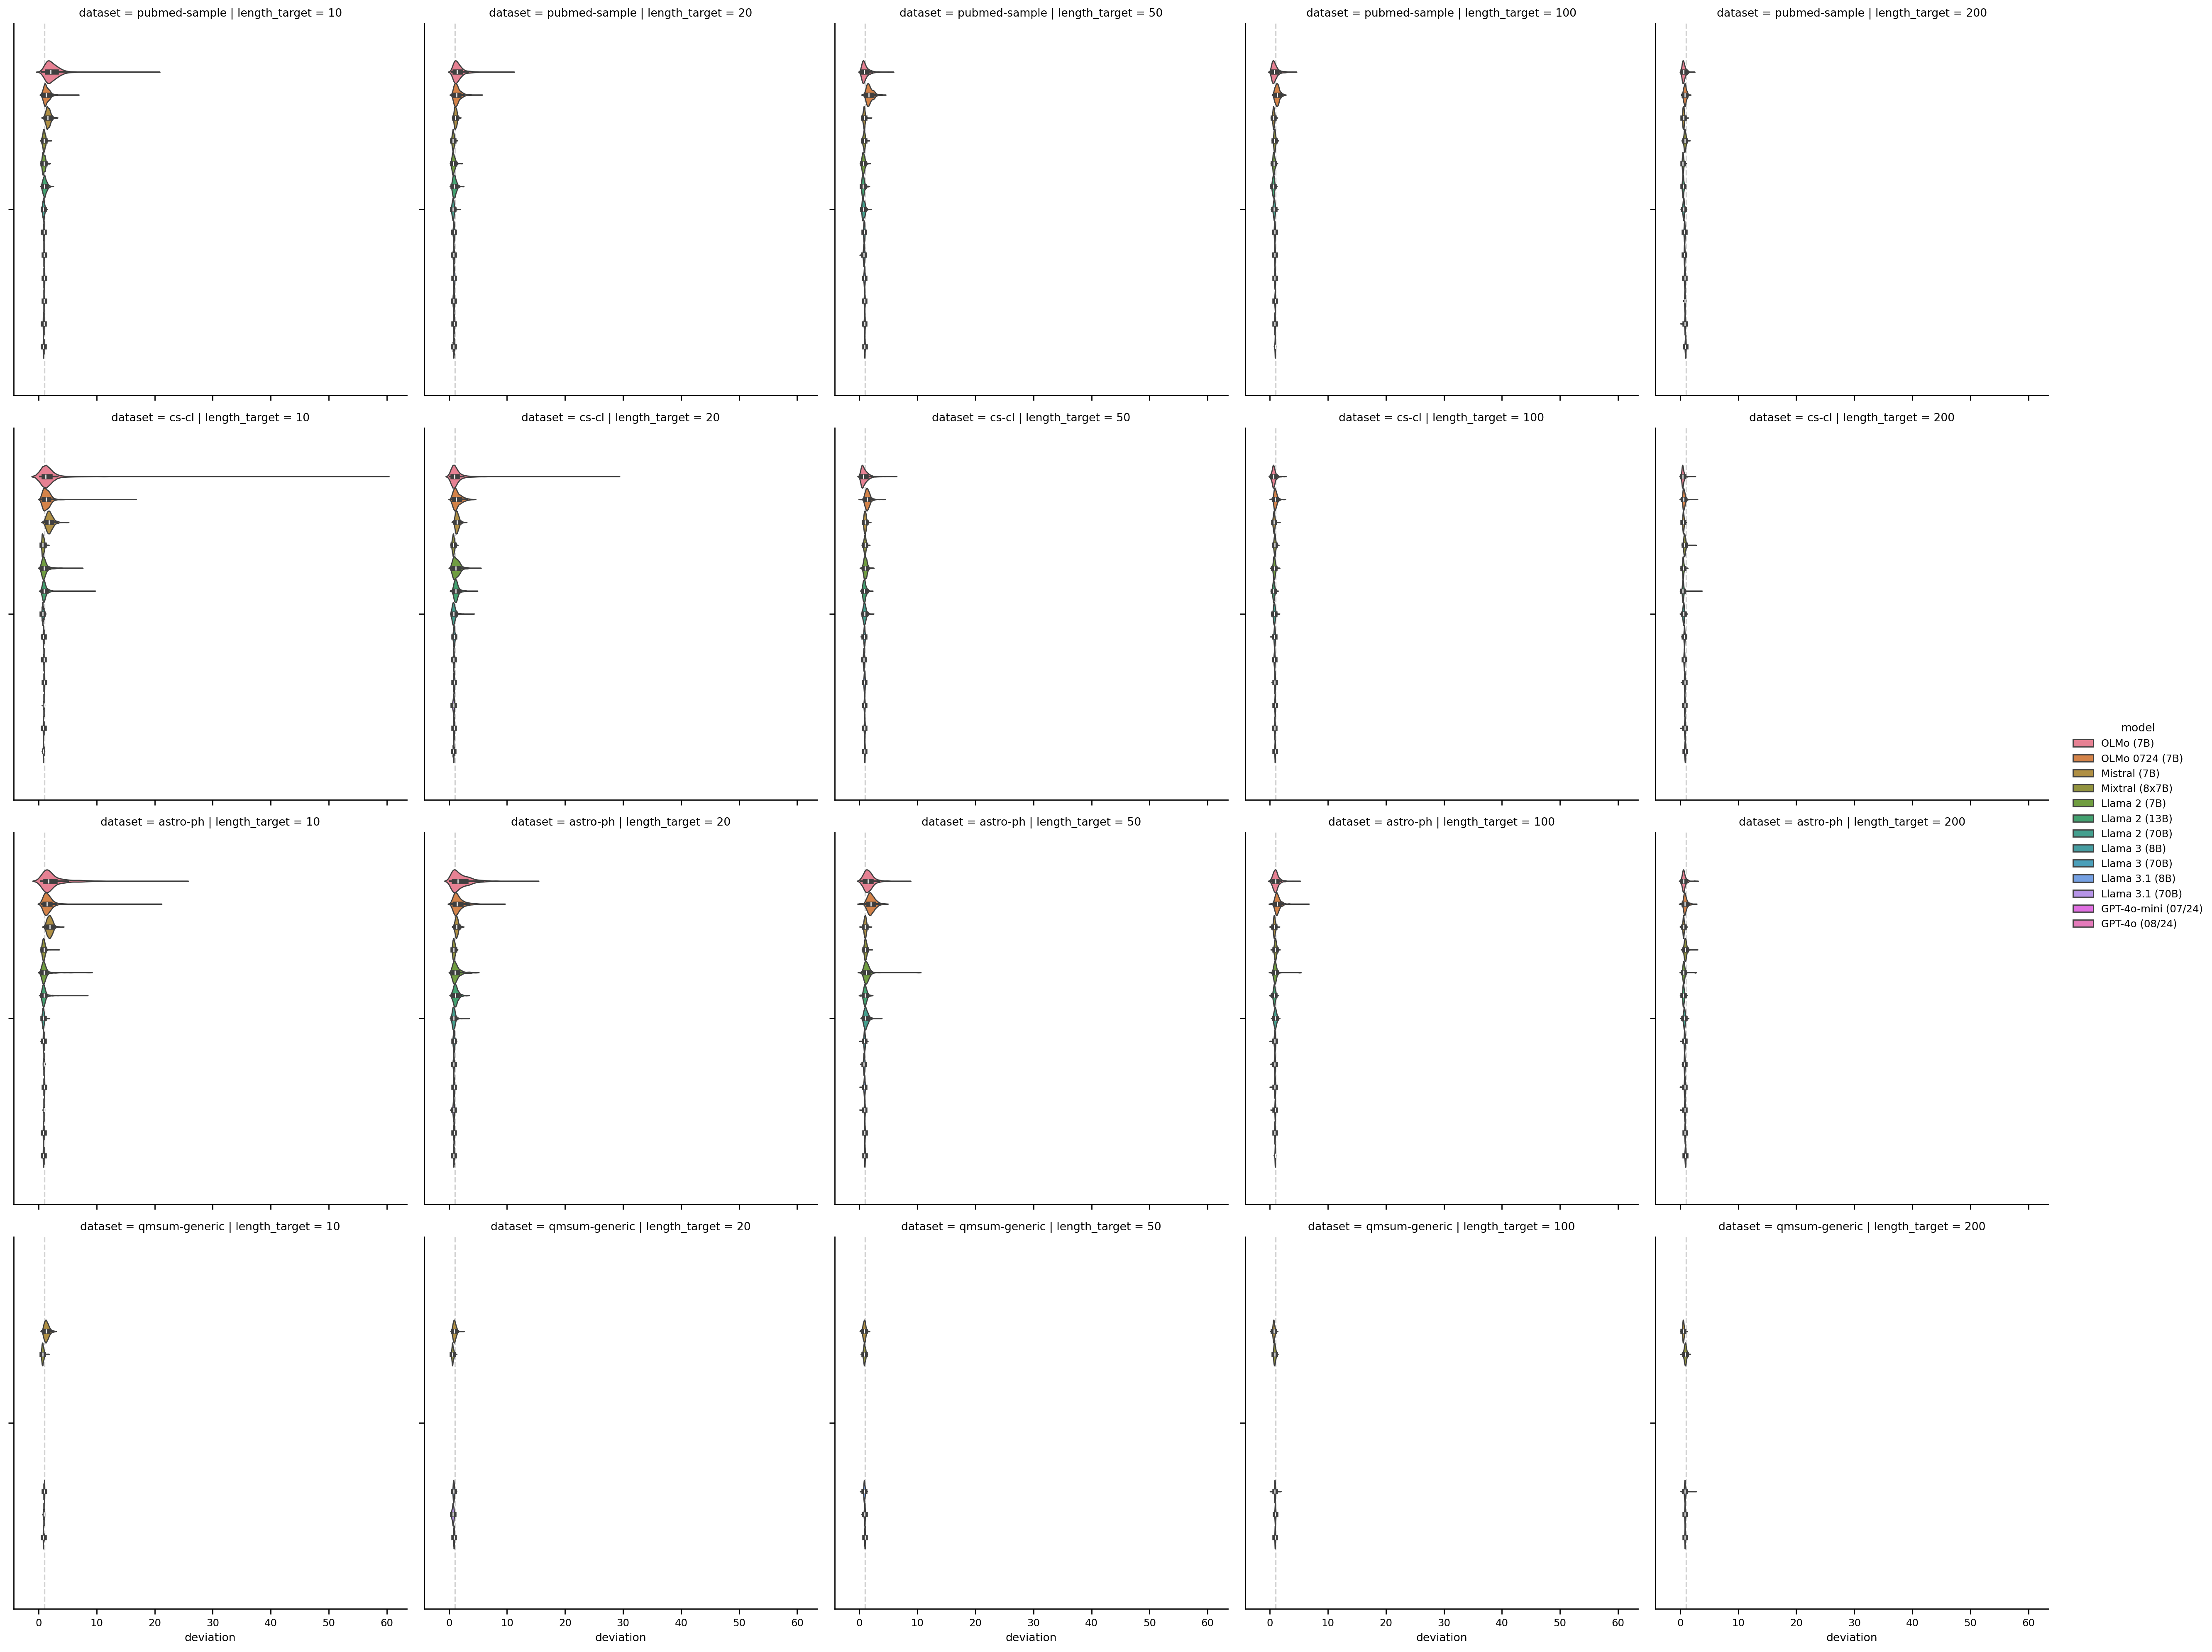

Without outliers


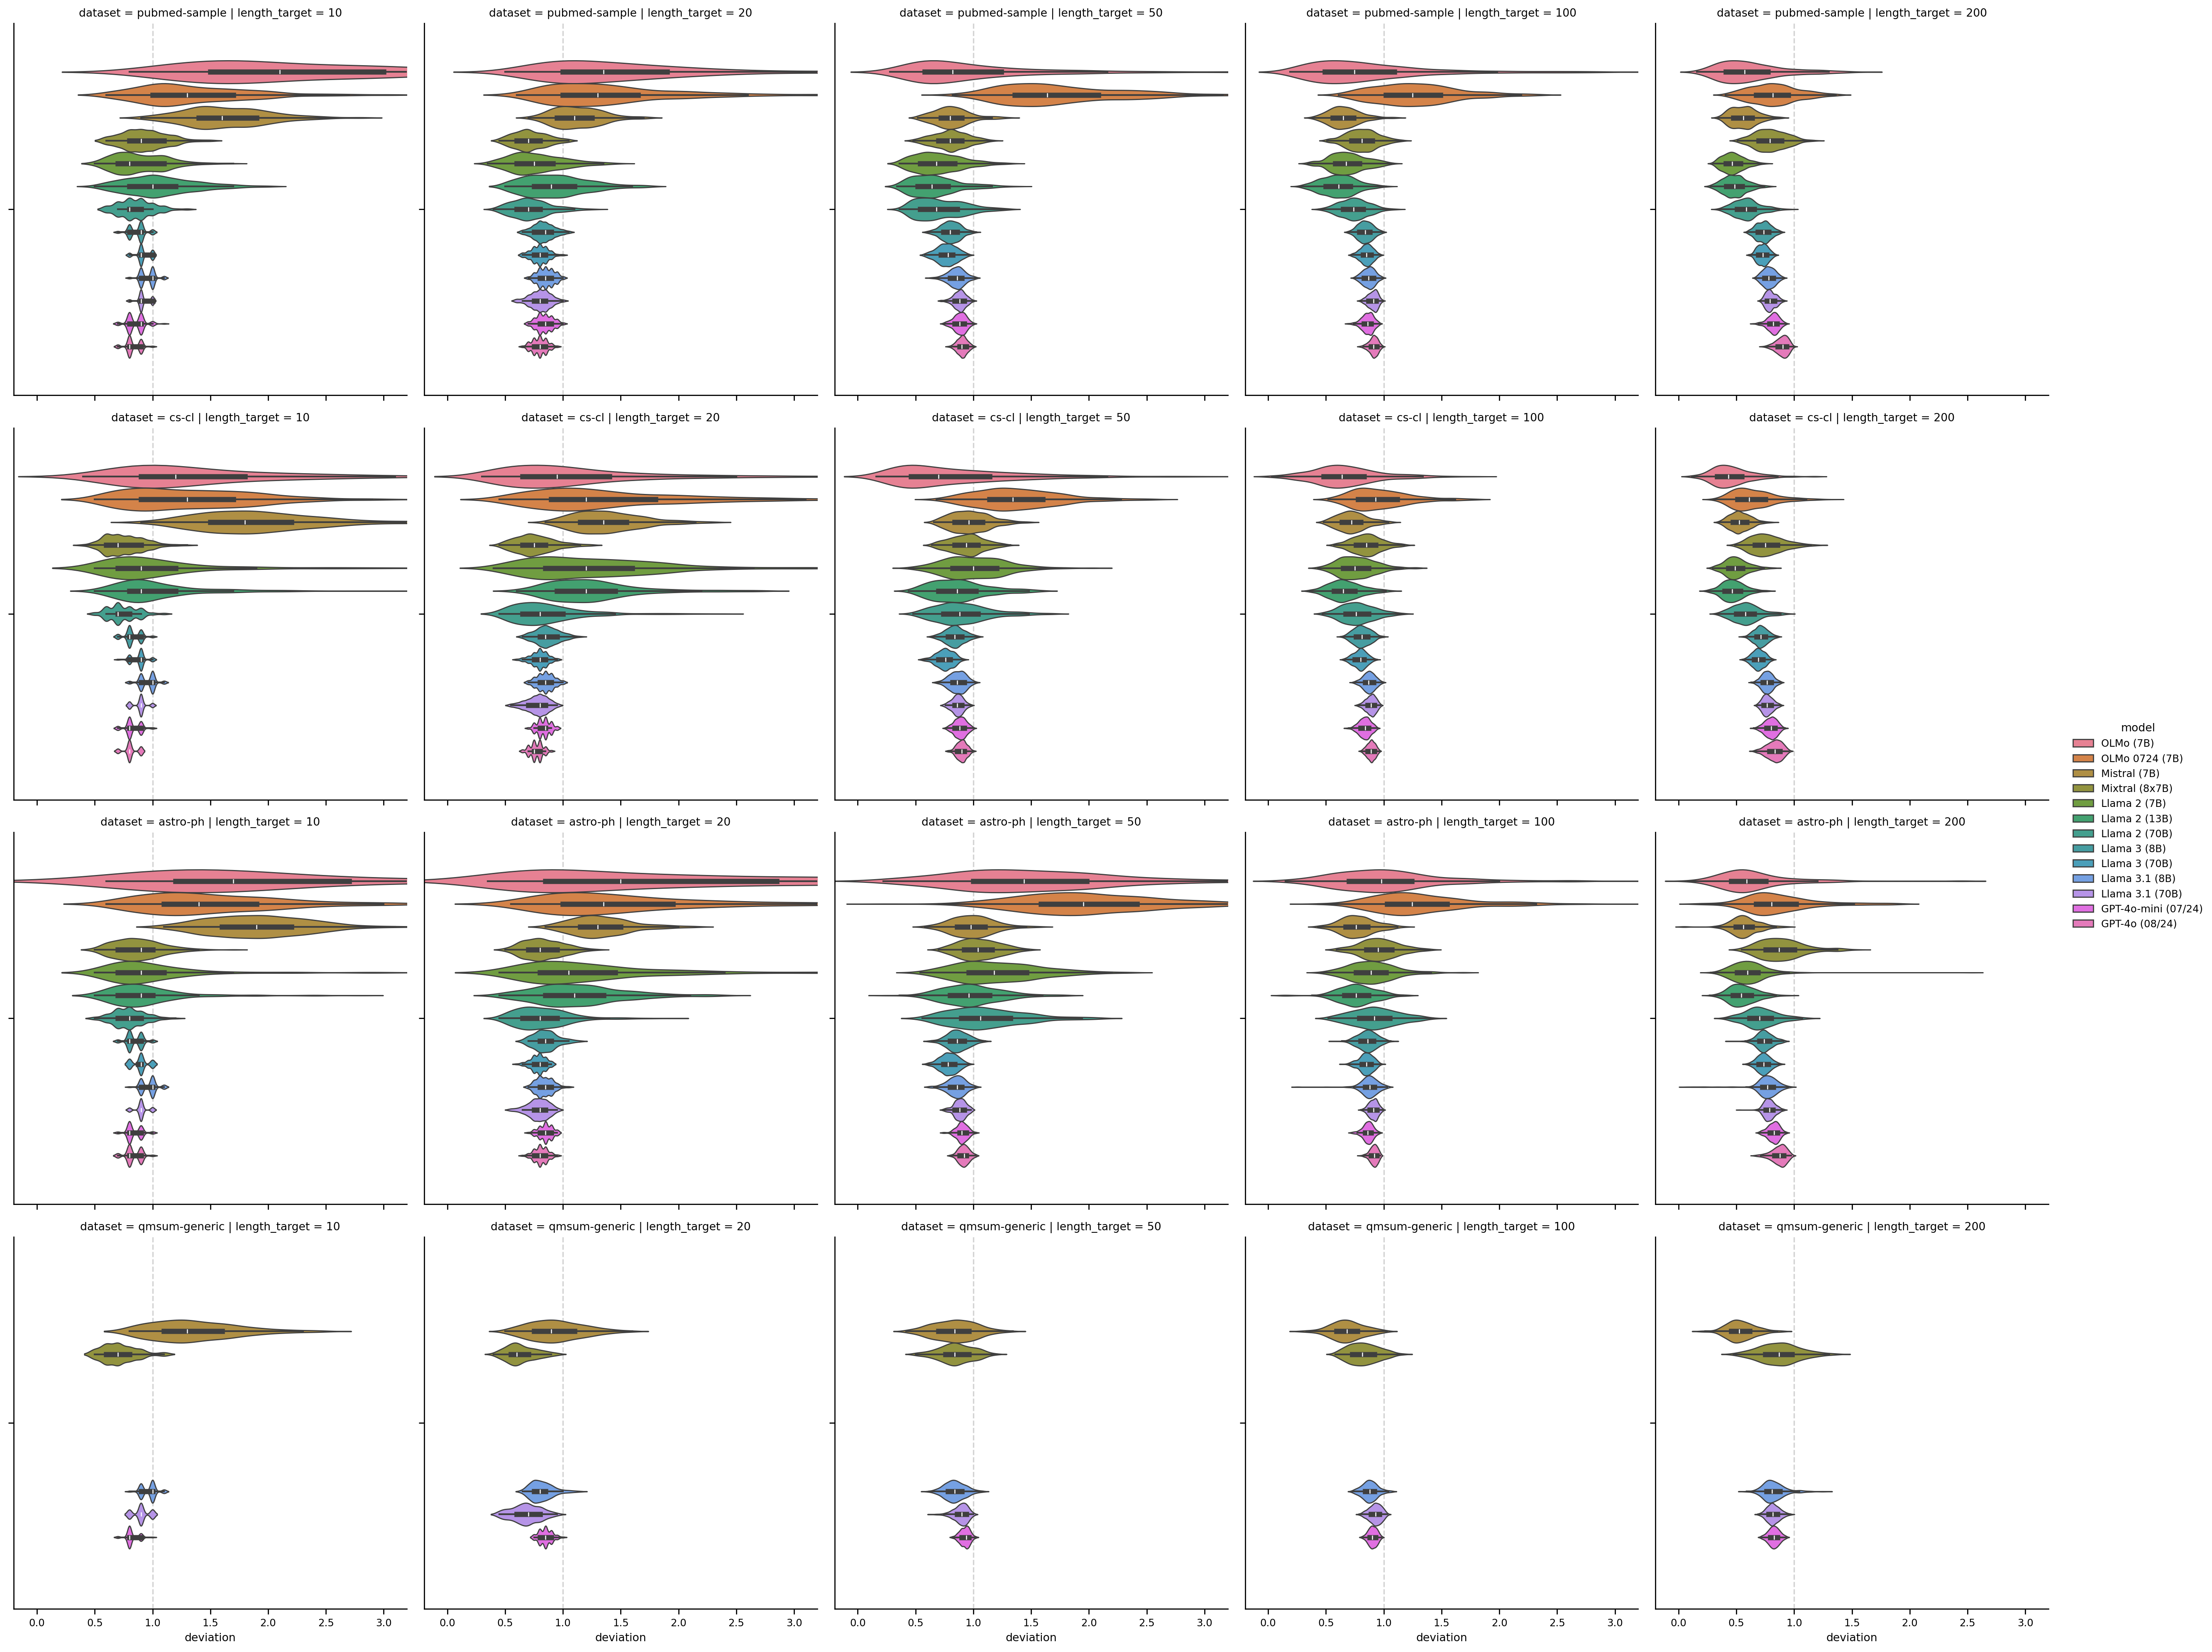

In [17]:
print('='*80)
print('With outliers')
print('='*80)
g = sns.catplot(df.reset_index(drop=True), x='deviation', hue='model', col='length_target', row='dataset', kind='violin', sharex=True, hue_order=order)
for ax in g.axes.ravel():
    ax.axvline(1, 0, 1, linestyle='--', color='lightgray', zorder=0)
plt.show()

print('='*80)
print('Without outliers')
print('='*80)
g = sns.catplot(df[~df['outlier']].reset_index(drop=True), x='deviation', hue='model', col='length_target', row='dataset', kind='violin', sharex=True, hue_order=order)
for ax in g.axes.ravel():
    ax.axvline(1, 0, 1, linestyle='--', color='lightgray', zorder=0)
g.set(xlim=[-0.2, 3.2])
plt.show()

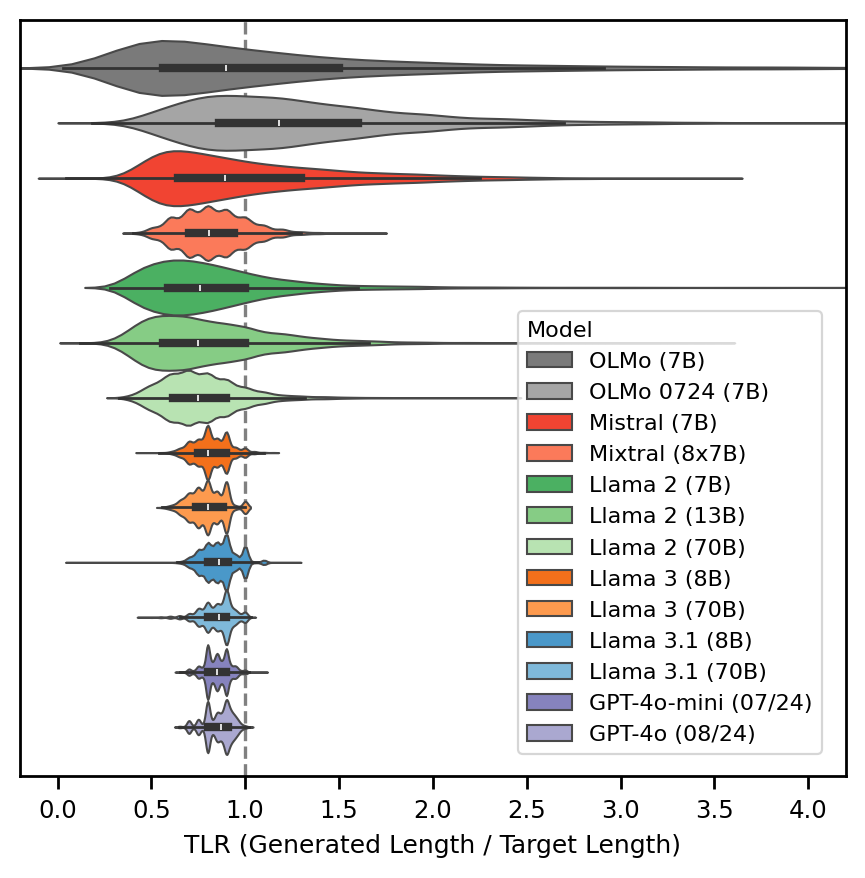

In [18]:
plot_data = df[~df['outlier']].reset_index(drop=True).copy()

g = sns.catplot(plot_data, x='deviation', hue='model', kind='violin', sharex=True, hue_order=order, palette=color, linewidth=0.75, saturation=1, legend_out=False, height=4.5, inner_kws=dict(box_width=3, whis_width=1, color=".2"))
plt.xlim([-0.2,4.2])
plt.axvline(1, 0, 1, linestyle='--', color='gray', zorder=0)
g.despine(right=False, top=False)
g.axes[0,0].margins(y=0.03, x=0.05)
g.tick_params(left=False)
plt.xlabel('TLR (Generated Length / Target Length)', fontsize=9)
sns.move_legend(g, "lower right", frameon=True, fontsize=8, title_fontsize=8, bbox_to_anchor=(0.95, 0.14))
g.legend.set_title('Model')
g.legend._legend_box.align = "left"

utils.savefig(g.fig, name='tlr', formats=['pdf'], path='../output/figures-paper/')

Models behave similarly across datsetes

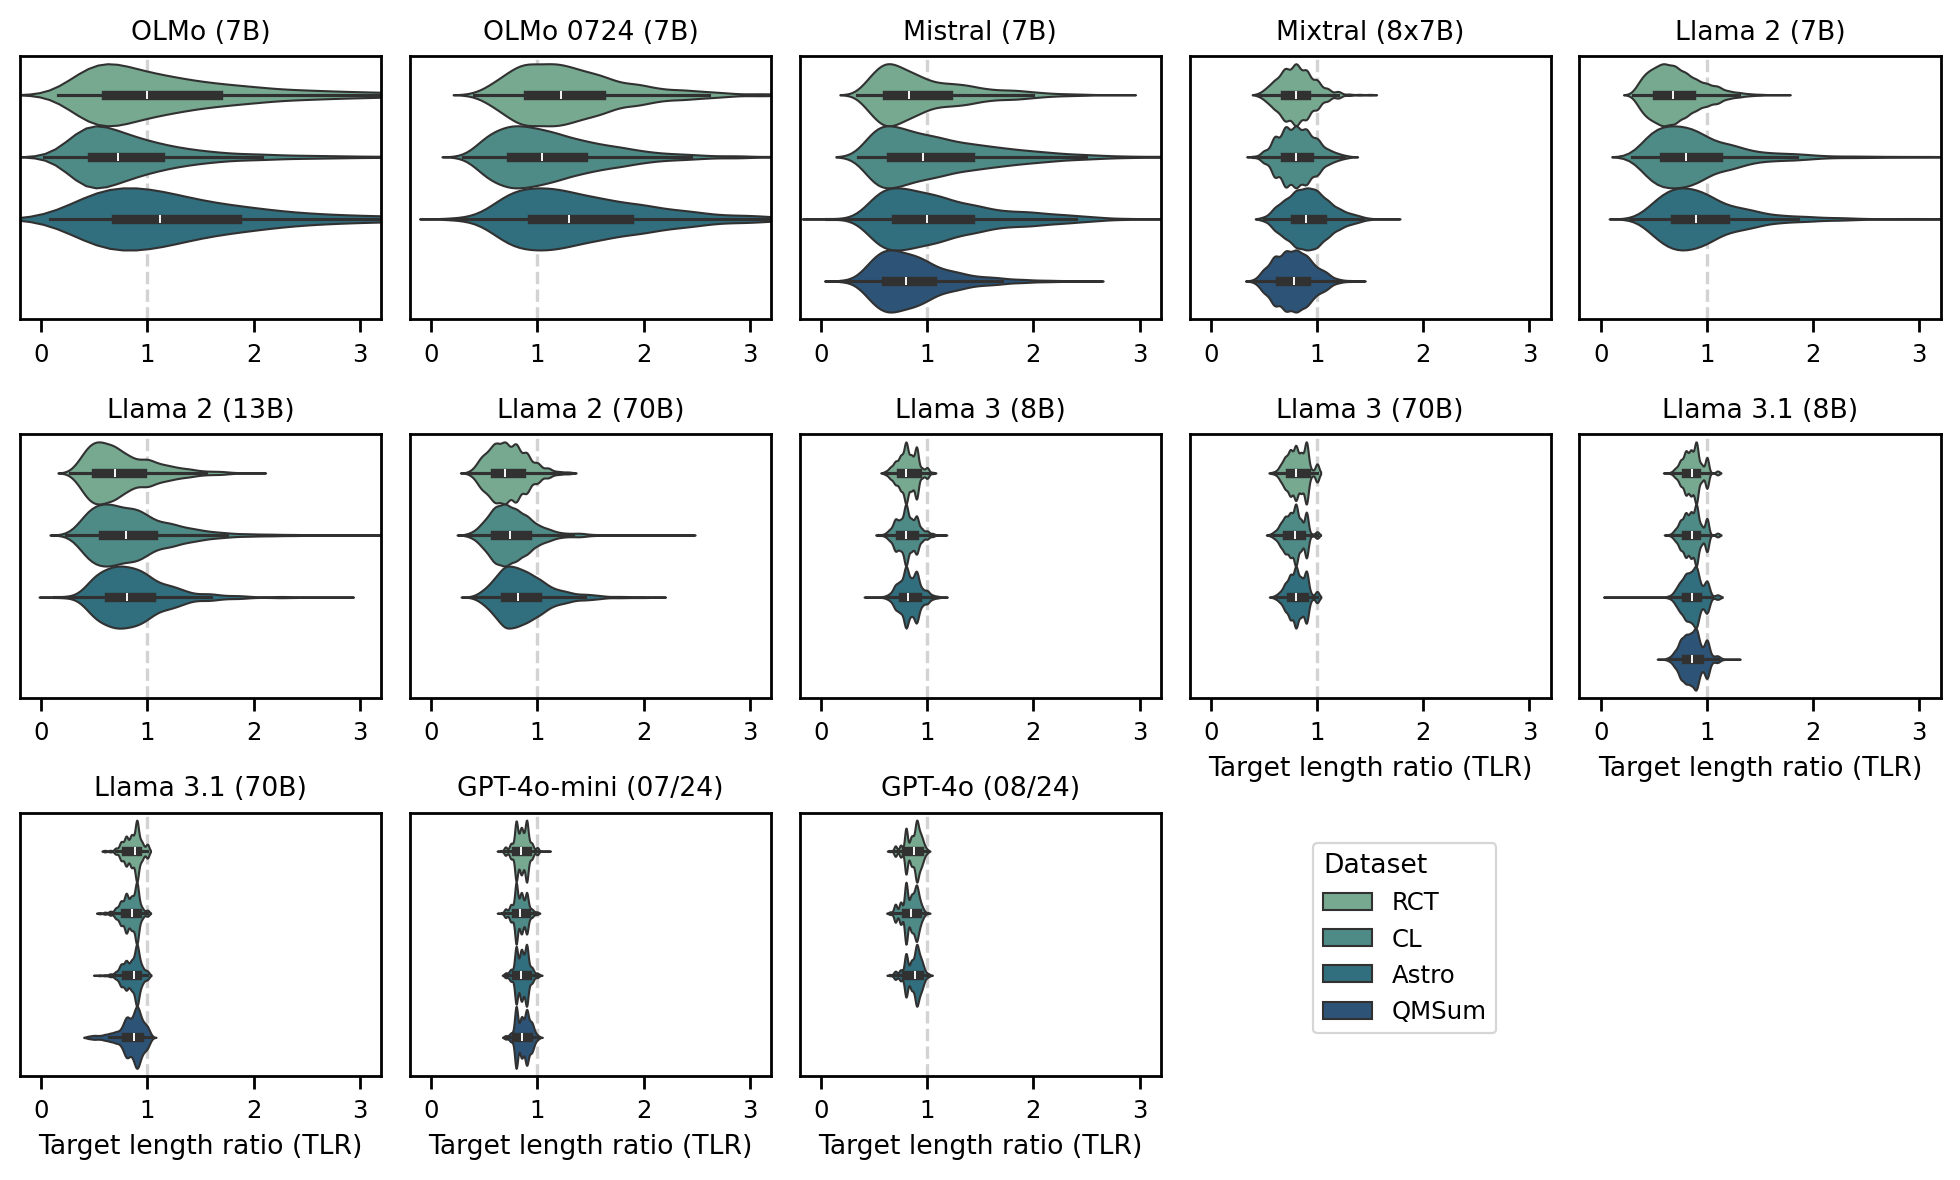

In [19]:
plot_data = df[~df['outlier']].reset_index(drop=True).copy()
plot_data['dataset'] = plot_data['dataset'].apply(lambda x: rename_dataset[x])

# col_order = model_ids_to_display_order(plot_data['model'])
# plot_data['model'] = model_ids_to_display_name(plot_data['model'])
# plot_data['length_target'] = plot_data['length_target'].apply(lambda x: f'{x} words')

g = sns.catplot(plot_data, x='deviation', hue='dataset', kind='violin', col='model', sharex=True, linewidth=0.75, col_wrap=5, palette='crest', height=2, col_order=order, facet_kws=dict(despine=False))
for ax in g.axes.ravel():
    ax.set_xlabel('Length deviation')
    ax.axvline(1, 0, 1, linestyle='--', color='lightgray', zorder=0)
    ax.margins(y=0.03)

g.set(xlim=[-0.2,3.2])
g.tick_params(labelbottom=True, left=False)
g.set_axis_labels('Target length ratio (TLR)', "")
g.set_titles(template="{col_name}")
sns.move_legend(g, "upper left", bbox_to_anchor=(.60, .30), title='Dataset', frameon=True)
g.legend._legend_box.align = "left"
g.tight_layout();

utils.savefig(g.fig, name='tlr-by-dataset', formats=['pdf'], path='../output/figures-paper/')

Models show slight variations across the length targets, but no conclusive trends. Slight trends:
- Weaker models get shorter as the target length increases (deviation increases: 10 > 20 > 50 > 100 > 200)
- Stronger models undergenerate on short targets (10, 20), and get slightly longer on the longer targets (50, 100, 200), but still undergenerate

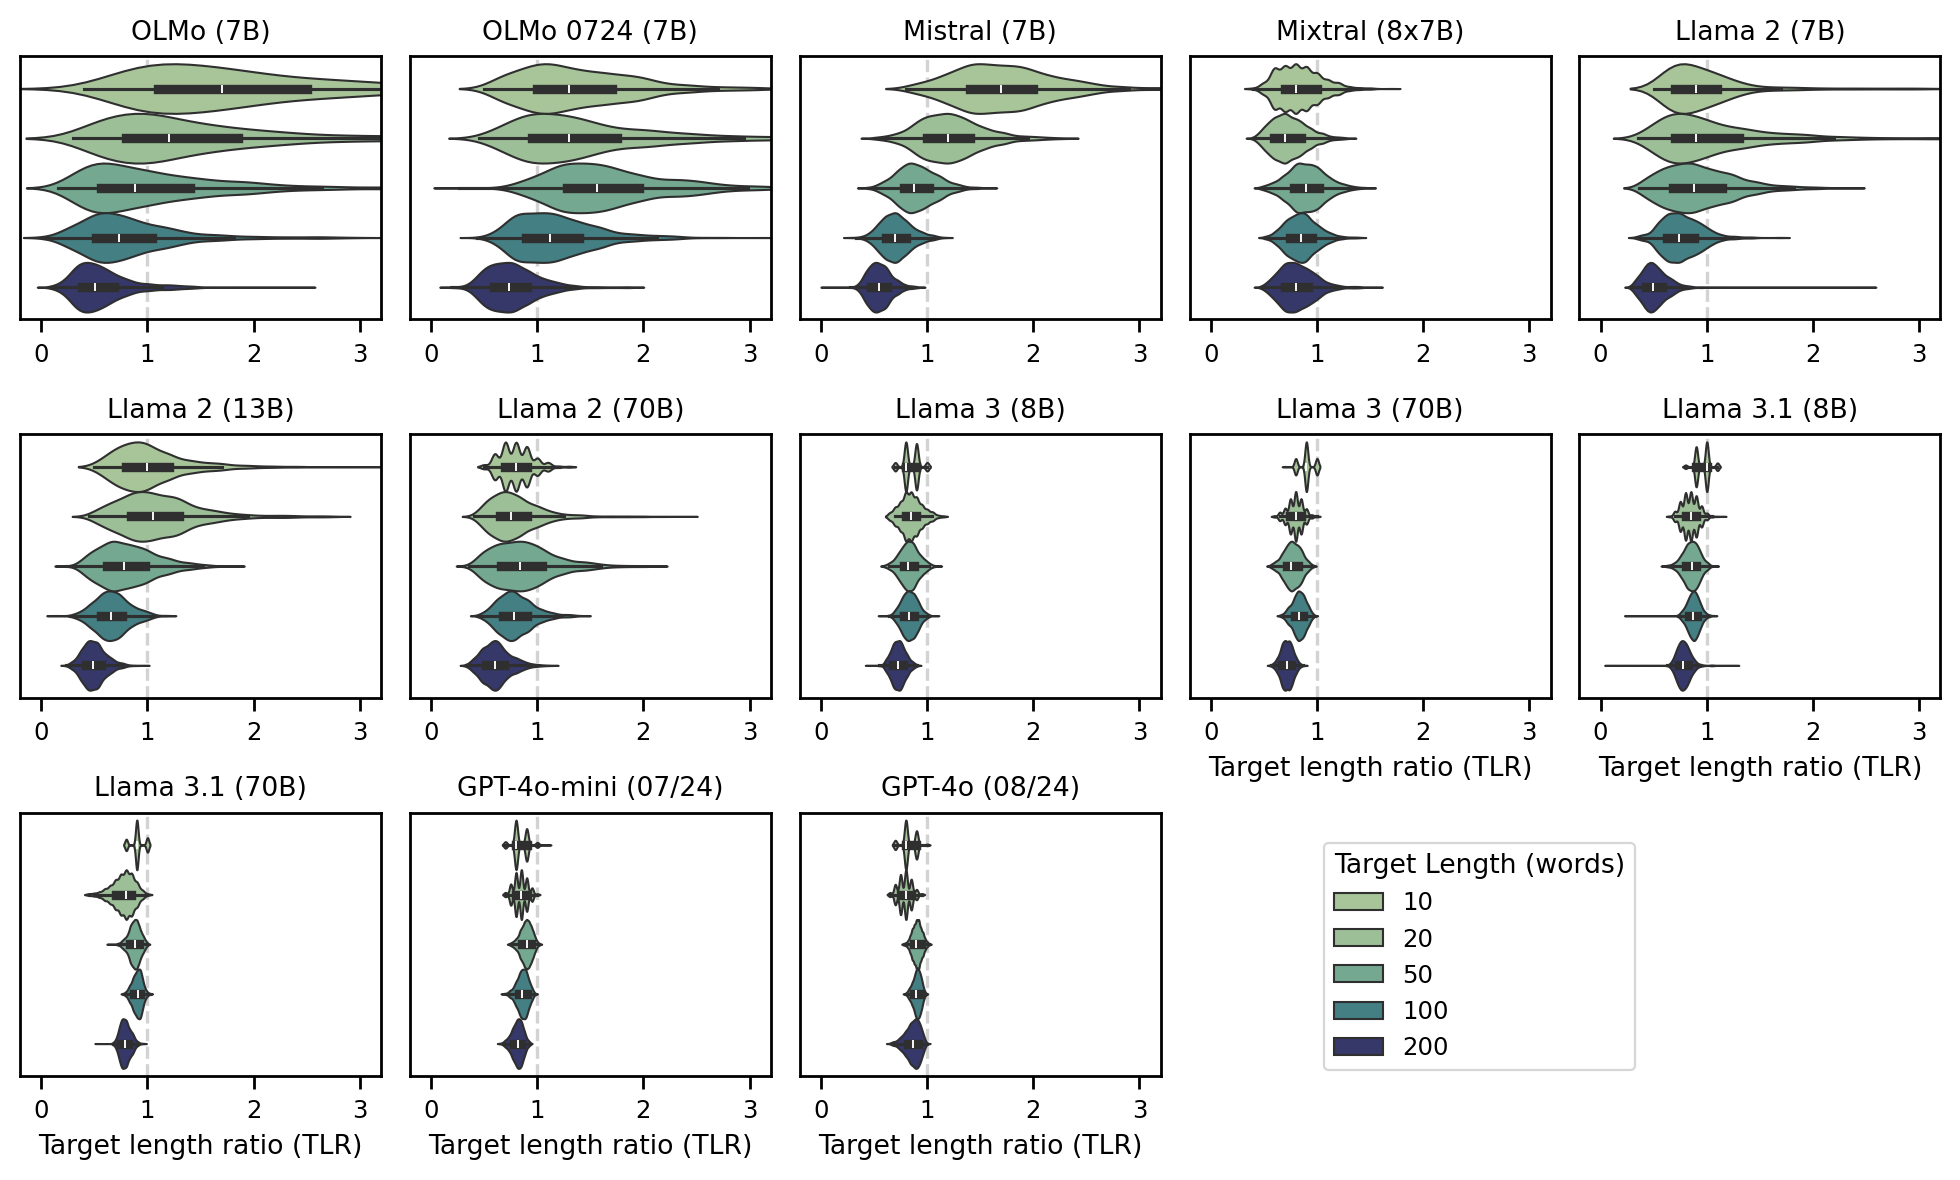

In [20]:
plot_data = df[~df['outlier']].reset_index(drop=True).copy()

# col_order = model_ids_to_display_order(plot_data['model'])
# plot_data['model'] = model_ids_to_display_name(plot_data['model'])
# plot_data['length_target'] = plot_data['length_target'].apply(lambda x: f'{x} words')

g = sns.catplot(plot_data, x='deviation', hue='length_target', kind='violin', col='model', sharex=True, linewidth=0.75, col_wrap=5, palette='crest', height=2, col_order=order, facet_kws=dict(despine=False))
for ax in g.axes.ravel():
    ax.axvline(1, 0, 1, linestyle='--', color='lightgray', zorder=0)
    ax.margins(y=0.03)

g.set(xlim=[-0.2,3.2])
g.tick_params(labelbottom=True, left=False)
g.set_axis_labels('Target length ratio (TLR)', "")
g.set_titles(template="{col_name}")
sns.move_legend(g, "upper left", bbox_to_anchor=(.60, .30), title='Target Length (words)', frameon=True)
g.legend._legend_box.align = "left"
g.tight_layout();

utils.savefig(g.fig, name='tlr-by-length', formats=['pdf'], path='../output/figures-paper/')

Average summary length as barplots

In [21]:
def plot_summary_length_by_model_and_target(df, order, dataset):
    g = sns.catplot(x="model", y='length_actual', col='length_target', data=df, kind='bar', sharey='col', order=order, errorbar='sd')
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(top=0.89)
    g.fig.suptitle(dataset)
    g.set_titles("{col_name} words")
    
    for ax, length_target in zip(g.axes.flat, g.col_names):
        target_length = int(length_target)
        ax.axhline(target_length, color='orange', linestyle='--')
        ax.set_xlabel(None)
        ax.set_ylabel('Summary length (words)')
    fig = g.fig
    return fig

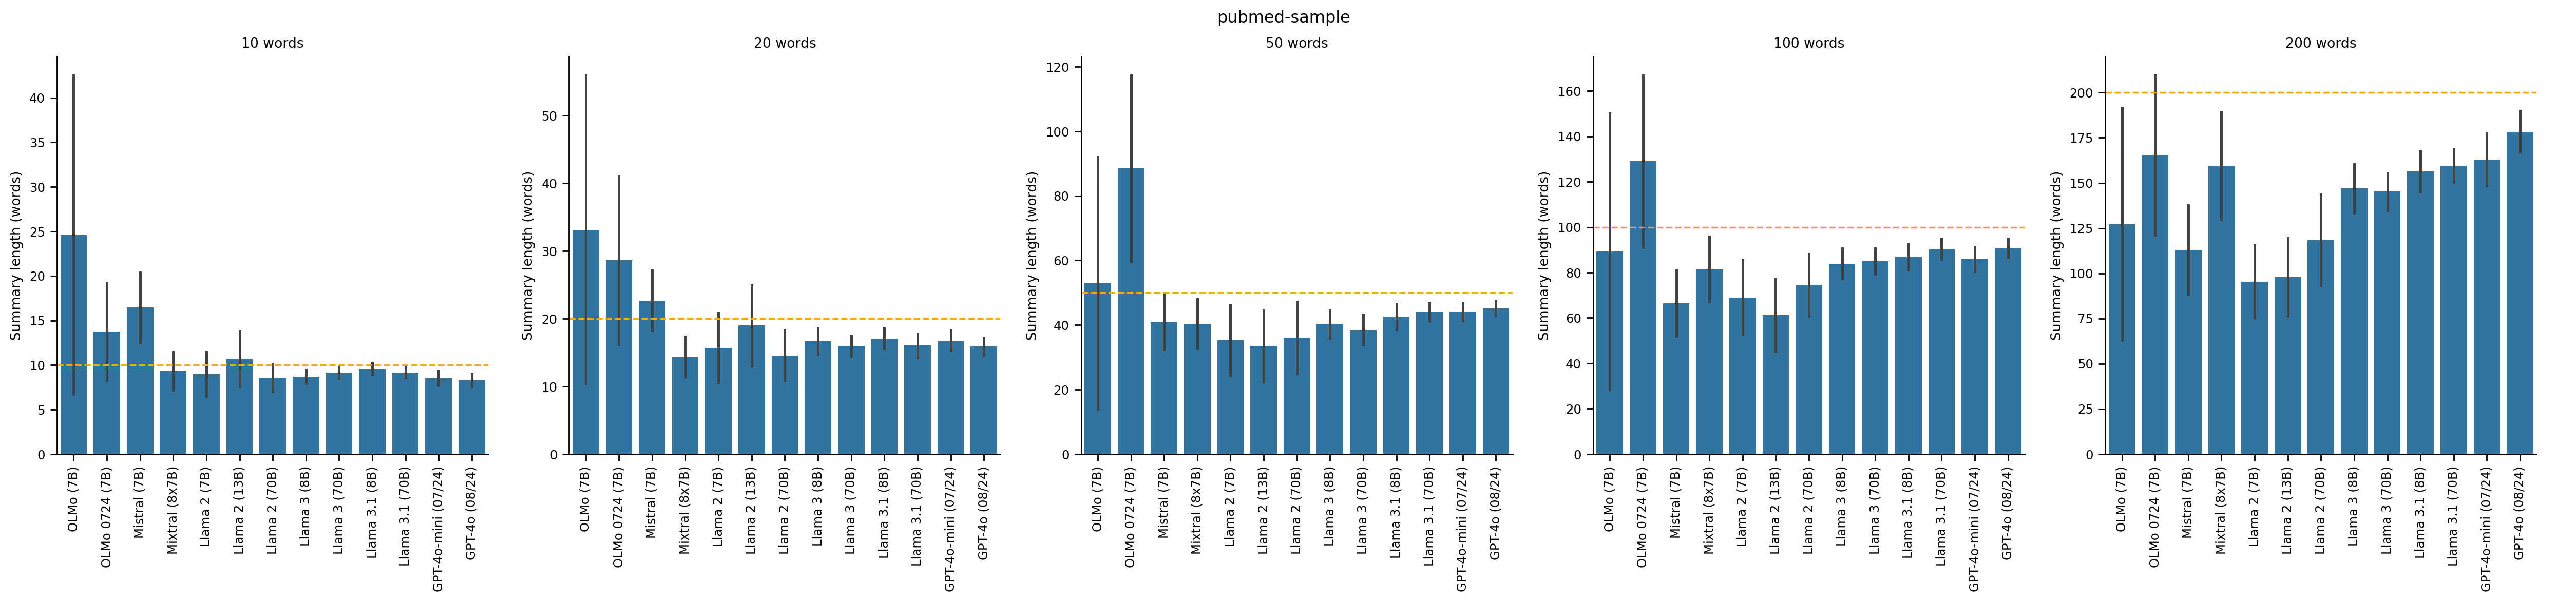

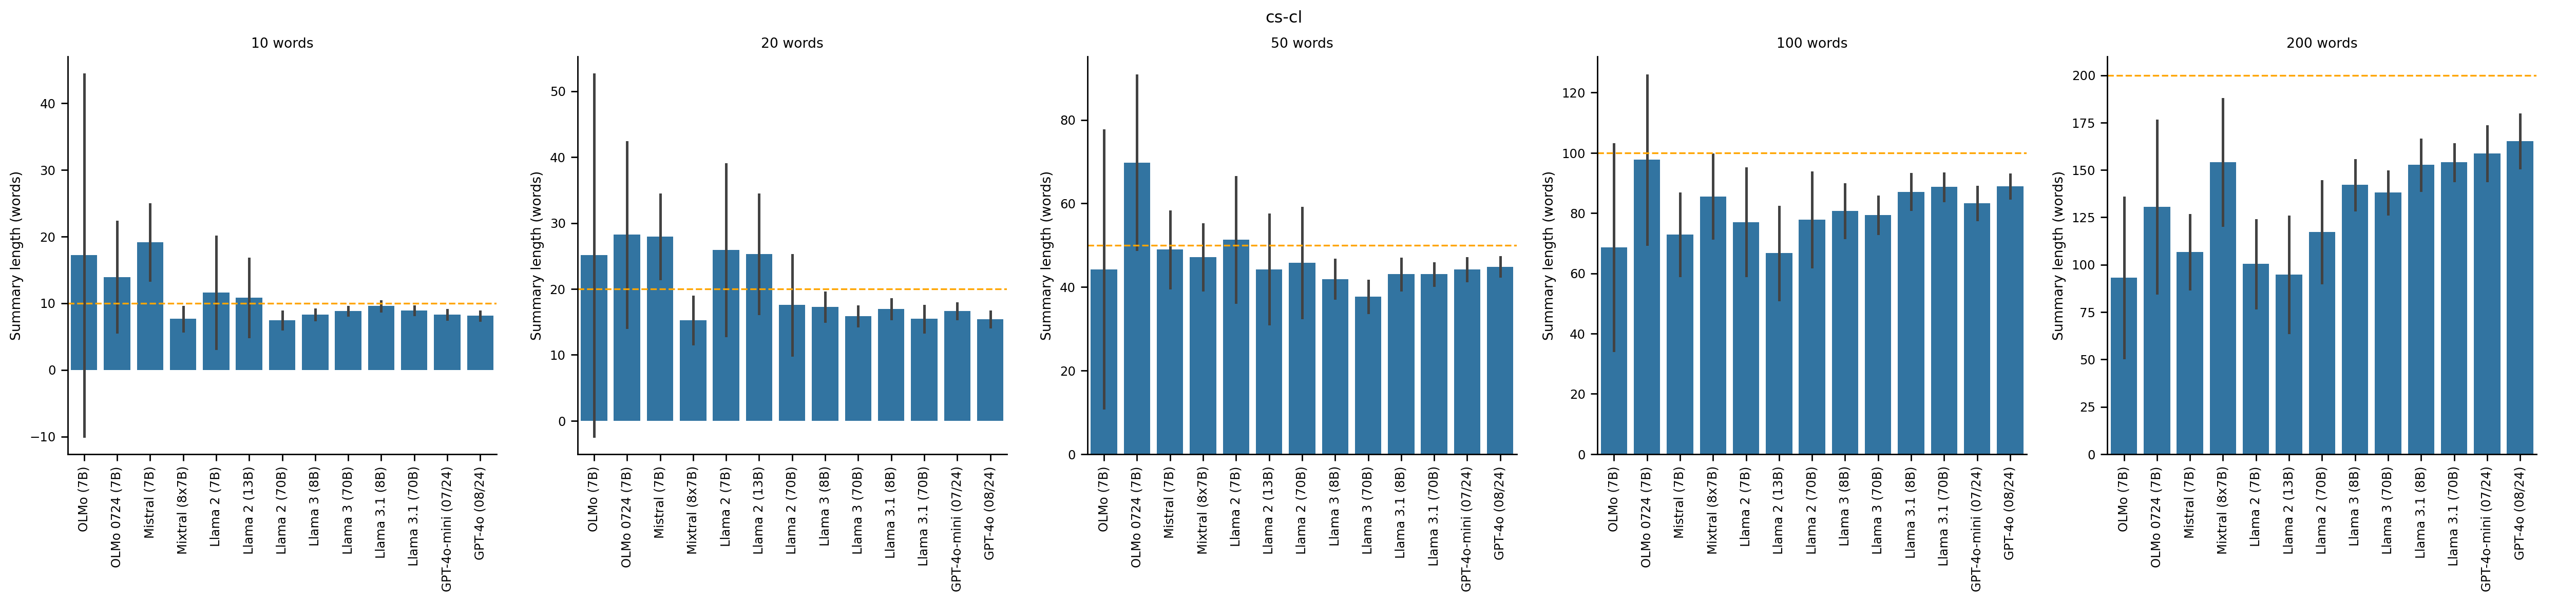

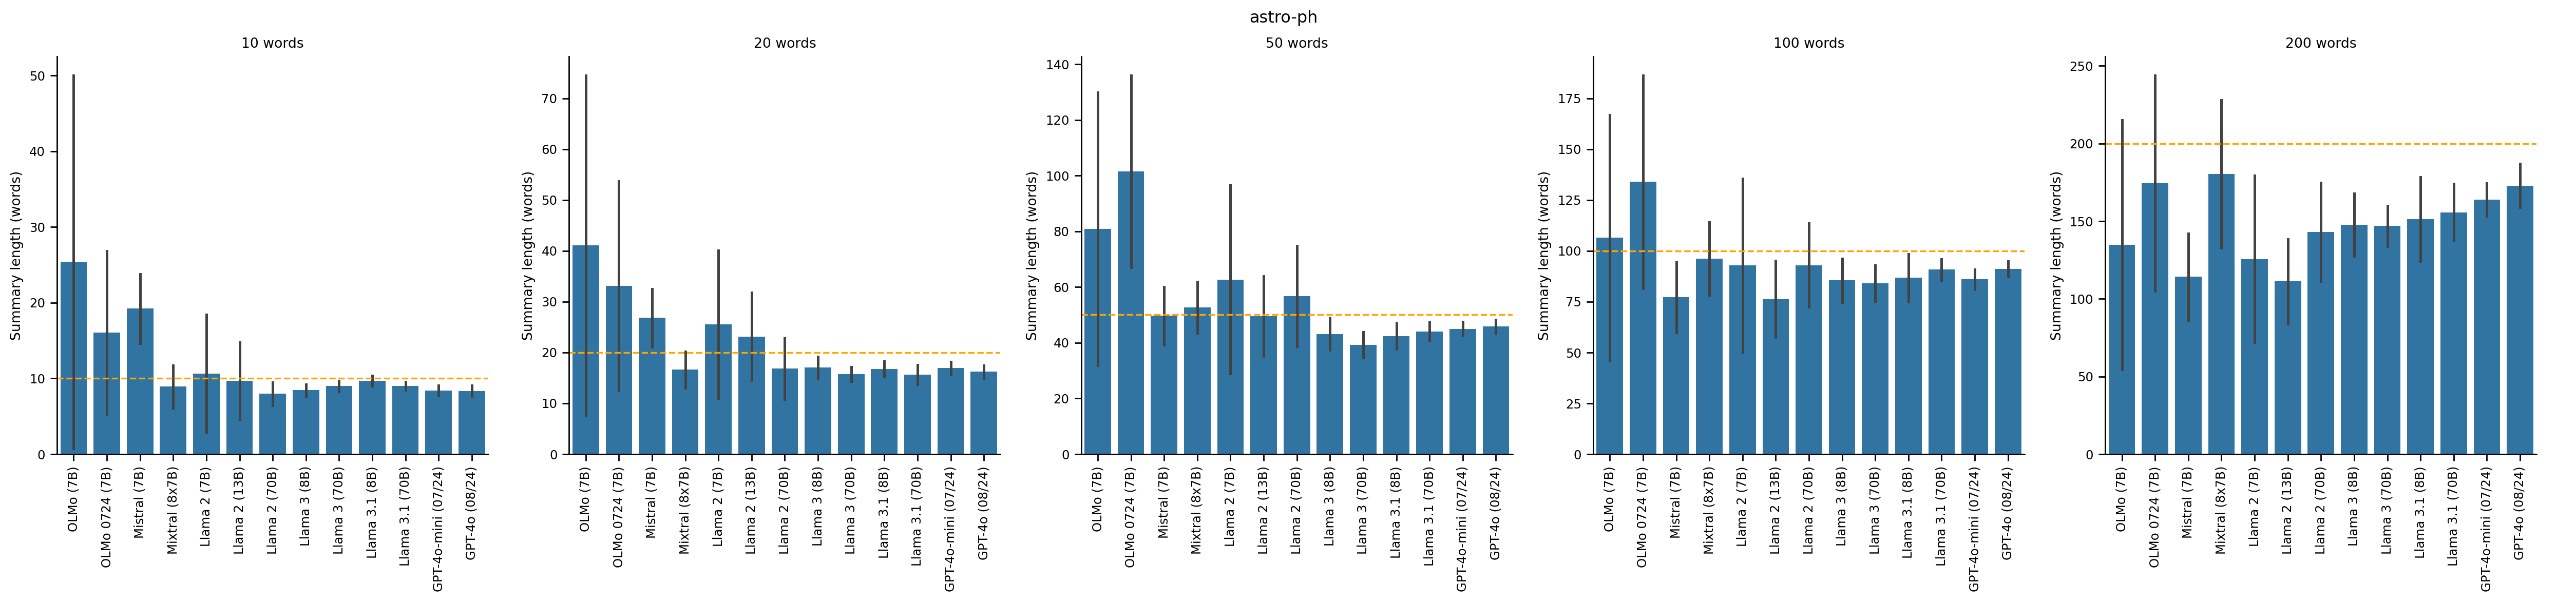

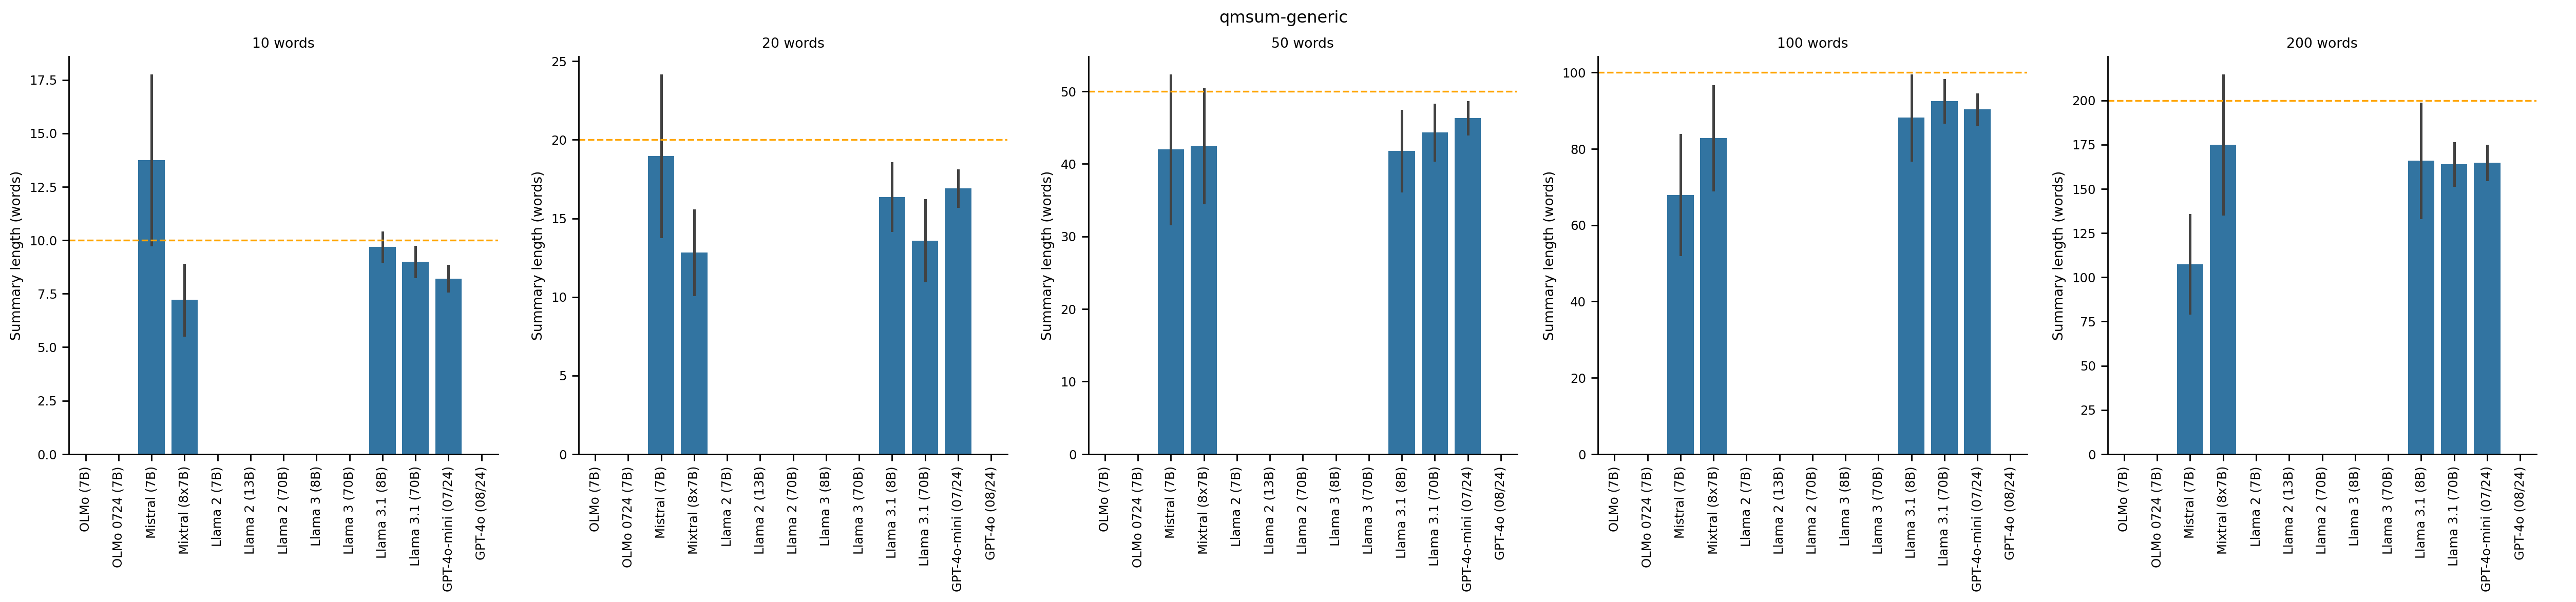

In [22]:
plot_summary_length_by_model_and_target(df[df['dataset'] == 'pubmed-sample'], order, 'pubmed-sample');
plot_summary_length_by_model_and_target(df[df['dataset'] == 'cs-cl'], order, 'cs-cl');
plot_summary_length_by_model_and_target(df[df['dataset'] == 'astro-ph'], order, 'astro-ph');
plot_summary_length_by_model_and_target(df[df['dataset'] == 'qmsum-generic'], order, 'qmsum-generic');

## Effect of temperature

### Average summary length

In [23]:
exclude_models = [
    "Meta-Llama-3.1-8B-Instruct-quantized.w8a8",
    "Meta-Llama-3.1-70B-Instruct-quantized.w8a8"
]

df = df_raw[
    (df_raw['length_actual'] > 0)
    & ~df_raw['model'].isin(exclude_models)
    & ~df_raw['model'].str.contains('gpt')
    & (df_raw['temperature'] >= 0)
    & (df_raw['dataset'] == 'pubmed-sample')
]
df = df.reset_index().copy()

df['deviation'] = df['length_actual'] / df['length_target']

order = model_ids_to_display_order(df['model'])
color = model_ids_to_display_color(df['model'])
df['model'] = model_ids_to_display_name(df['model'])

print(len(df))

1108945


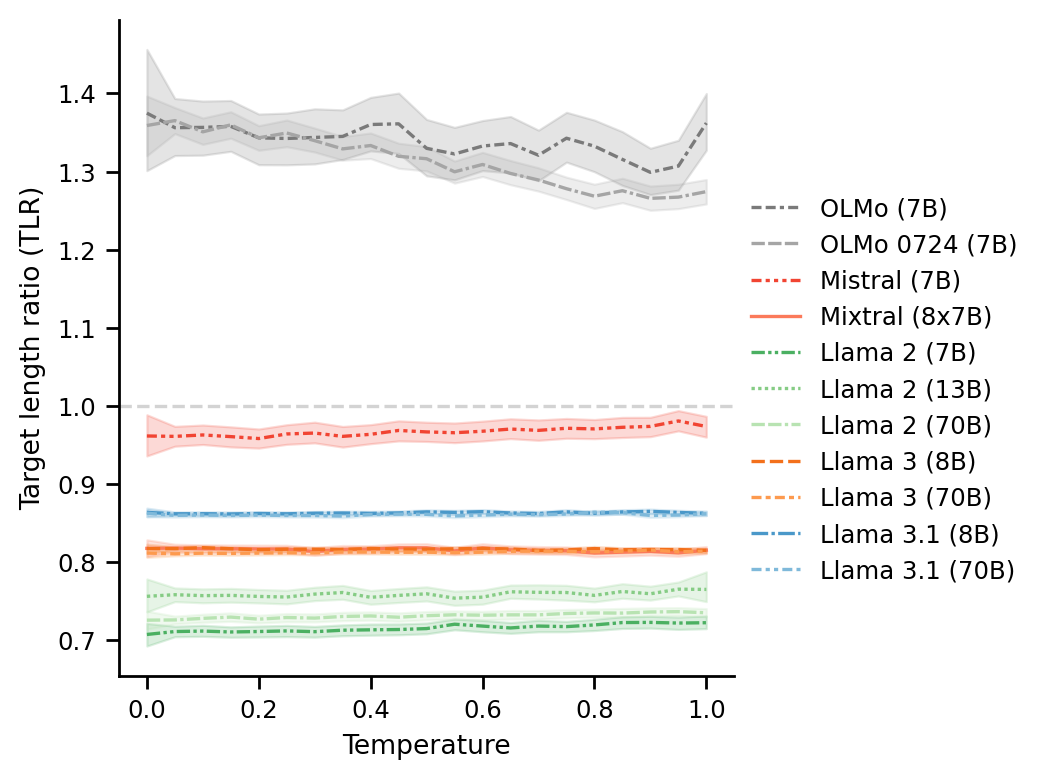

In [24]:
g = sns.relplot(
    df,
    kind='line',
    x='temperature',
    y='deviation',
    hue='model',
    style='model',
    palette=color,
    hue_order=order,
    markers=False,
    dashes=True,
    facet_kws={'legend_out': True},
    height=4,
)
g.ax.axhline(1, 0, 1, linestyle='--', color='lightgray', zorder=0)
g.tick_params(labelbottom=True)
g.set_axis_labels("Temperature", "Target length ratio (TLR)")
sns.move_legend(g, "center right", title=None)

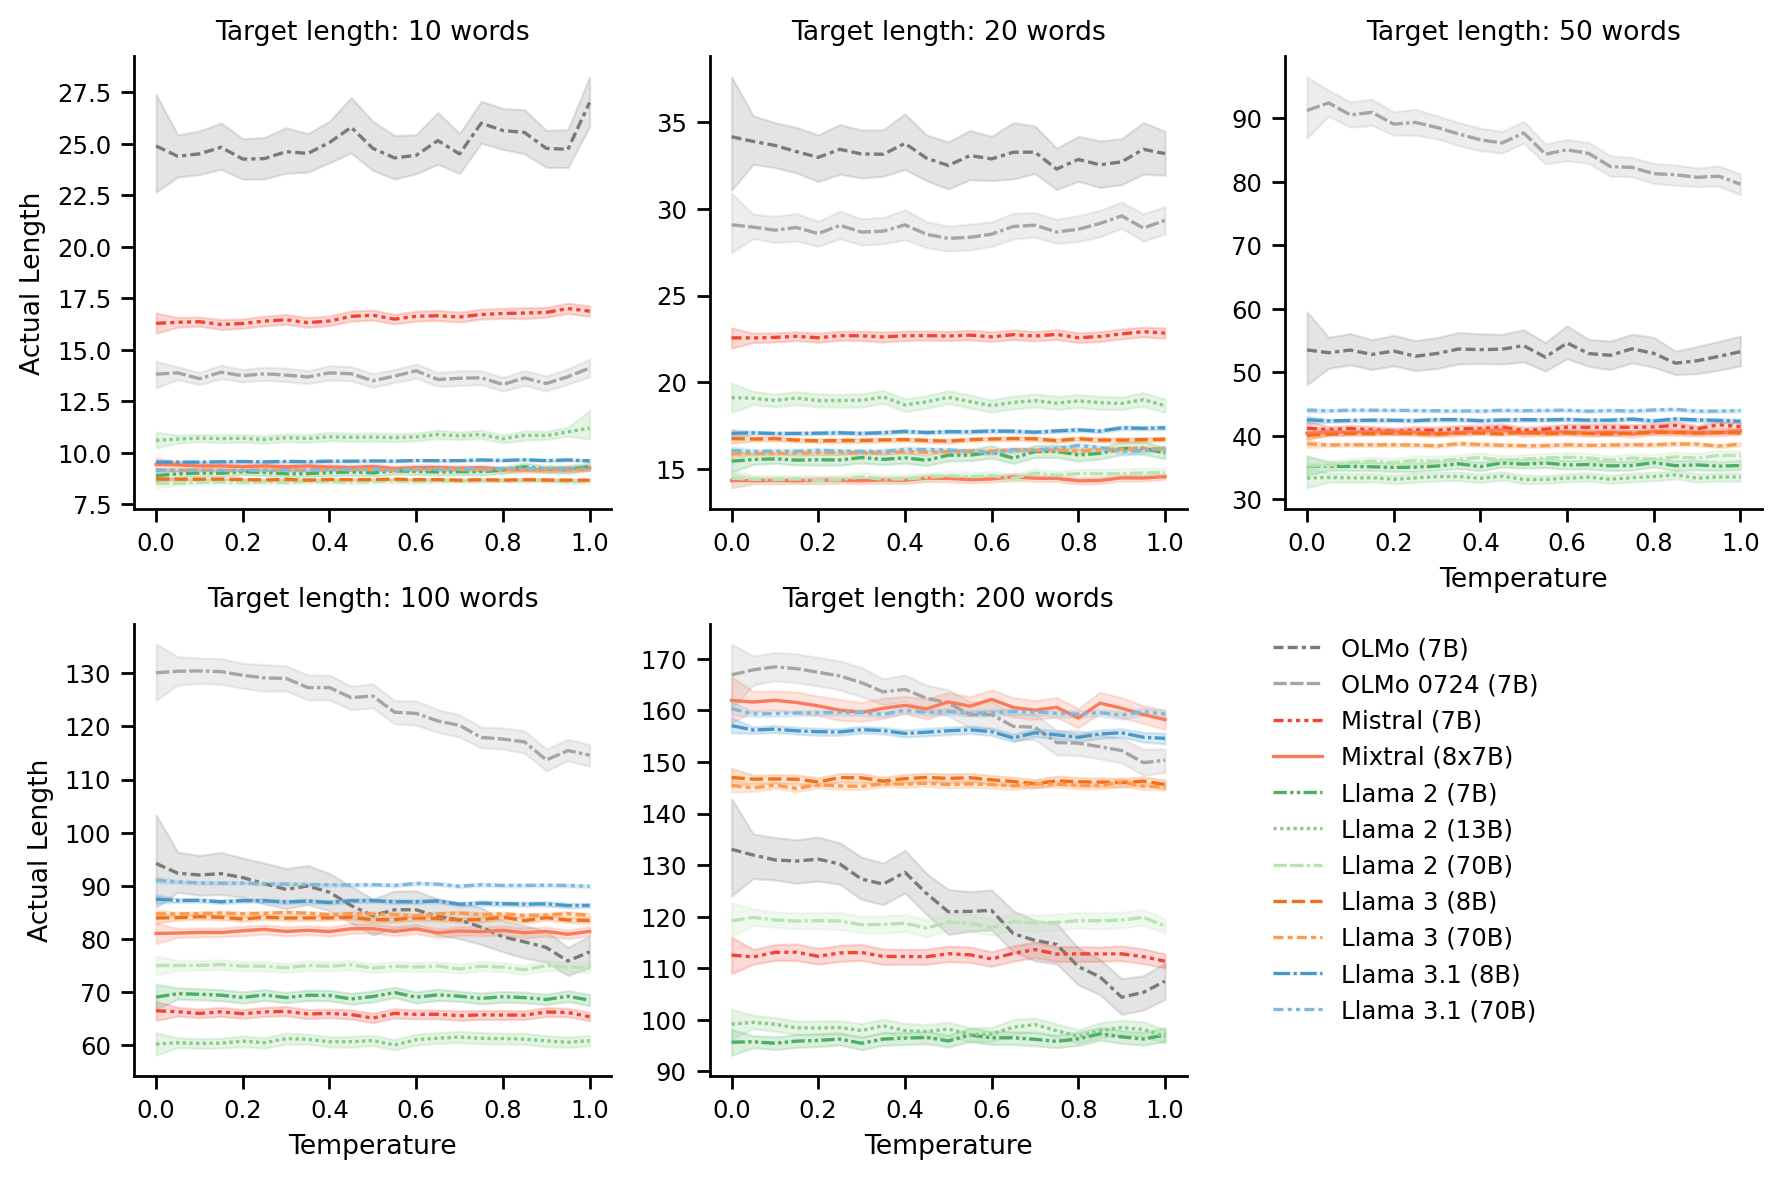

In [25]:
g = sns.relplot(
    df,
    kind='line',
    x='temperature',
    y='length_actual',
    hue='model',
    style='model',
    col='length_target',
    col_wrap=3,
    palette=color,
    hue_order=order,
    markers=False,
    dashes=True,
    facet_kws={'legend_out': False, 'sharey': False},
    height=3
)

g.tick_params(labelbottom=True)
g.set_axis_labels("Temperature", "Actual Length")
g.set_titles(template="Target length: {col_name} words")
sns.move_legend(g, "upper left", bbox_to_anchor=(.7, .48), frameon=False, title=None);

### Within-document length variance

In [26]:
def mean_absolute_deviation_from_mean(l):
    c = np.mean(l)
    return np.mean(np.abs(l - c)) 

In [27]:
df_mad = df.groupby(['model', 'doc_id', 'length_target', 'temperature'])['length_actual'].apply(mean_absolute_deviation_from_mean).rename('mad').reset_index()
df_mad['mad_normalized'] = df_mad['mad'] / df_mad['length_target']
df_mad.head()

model    doc_id  length_target  temperature   mad  mad_normalized
0  Llama 2 (13B)  38157711             10         0.00  0.00           0.000
1  Llama 2 (13B)  38157711             10         0.05  0.00           0.000
2  Llama 2 (13B)  38157711             10         0.10  0.00           0.000
3  Llama 2 (13B)  38157711             10         0.15  0.00           0.000
4  Llama 2 (13B)  38157711             10         0.20  0.32           0.032

For all models and target lengths separately. Following trends:
- MAD increases with temperature
- More recent models have smaller MAD
- MAD develops similarly for target lengths, except for OLMo, which is bad at instruction following

Within-document length variance (aggregated across all target lengths)


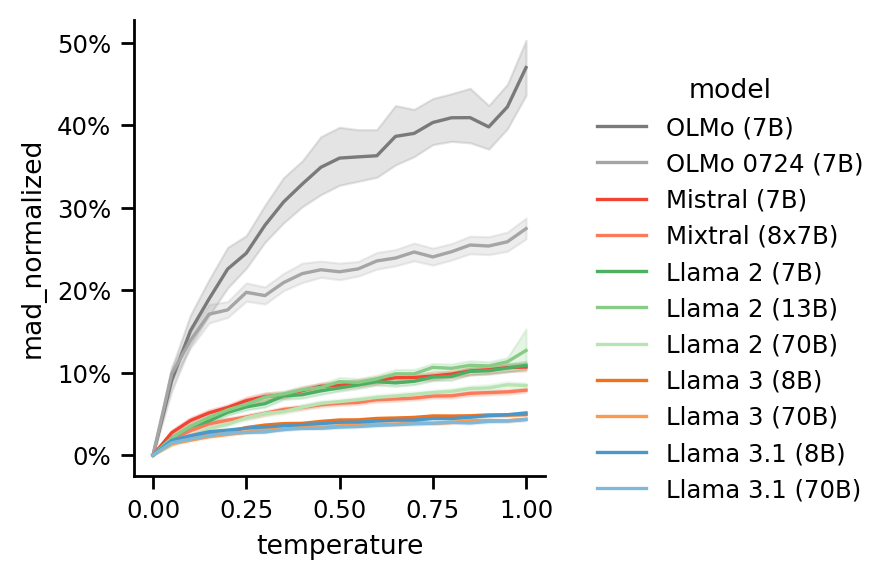

Within-document length variance (by model and target length)


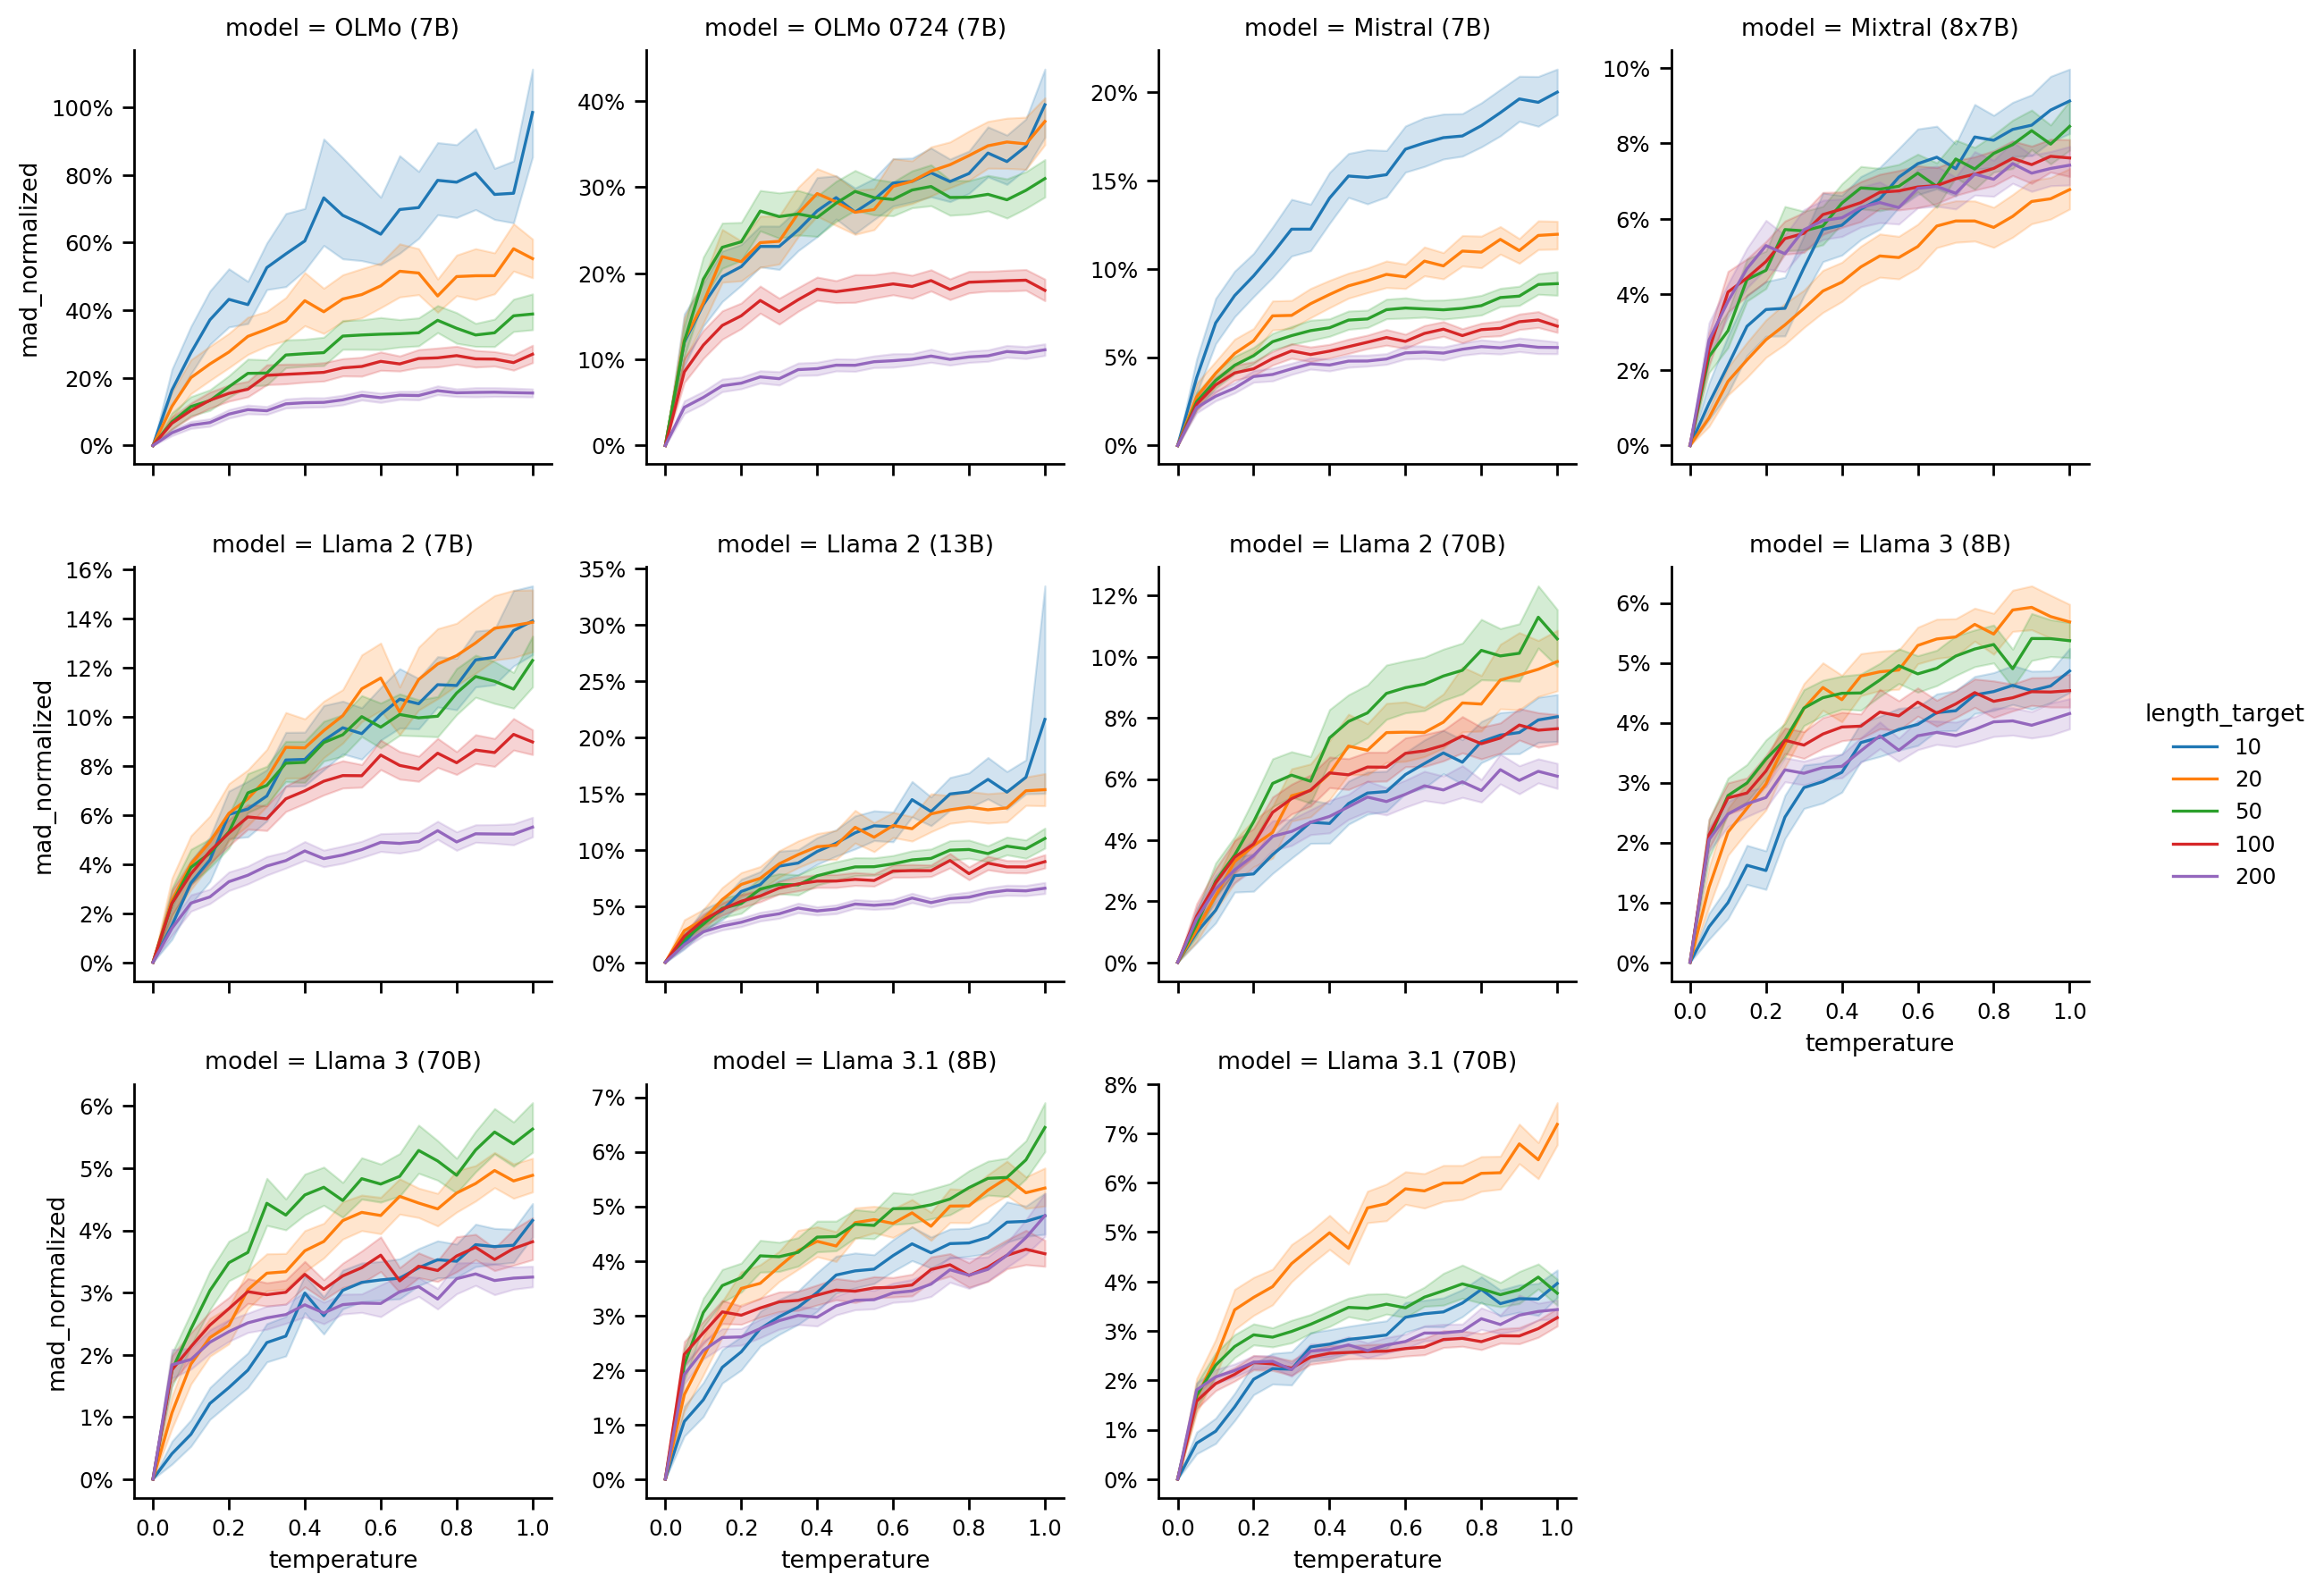

In [28]:
print('='*80)
print('Within-document length variance (aggregated across all target lengths)')
print('='*80)

g = sns.relplot(
    data=df_mad,
    x='temperature',
    y='mad_normalized',
    hue='model',
    hue_order=order,
    palette=color,
    kind='line',
    height=3,
    facet_kws={'sharey': False}
)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
# g.set(ylim=[-0.02, 0.32])
g.tight_layout()
plt.show()

print('='*80)
print('Within-document length variance (by model and target length)')
print('='*80)

g = sns.relplot(
    data=df_mad,
    x='temperature',
    y='mad_normalized',
    hue='length_target',
    col='model',
    col_wrap=4,
    col_order=order,
    palette='tab10',
    kind='line',
    height=3,
    facet_kws={'sharey': False}
)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
# g.set(ylim=[-0.02, 0.32])
g.tight_layout()

## Combine average summary length and MAD into single plot

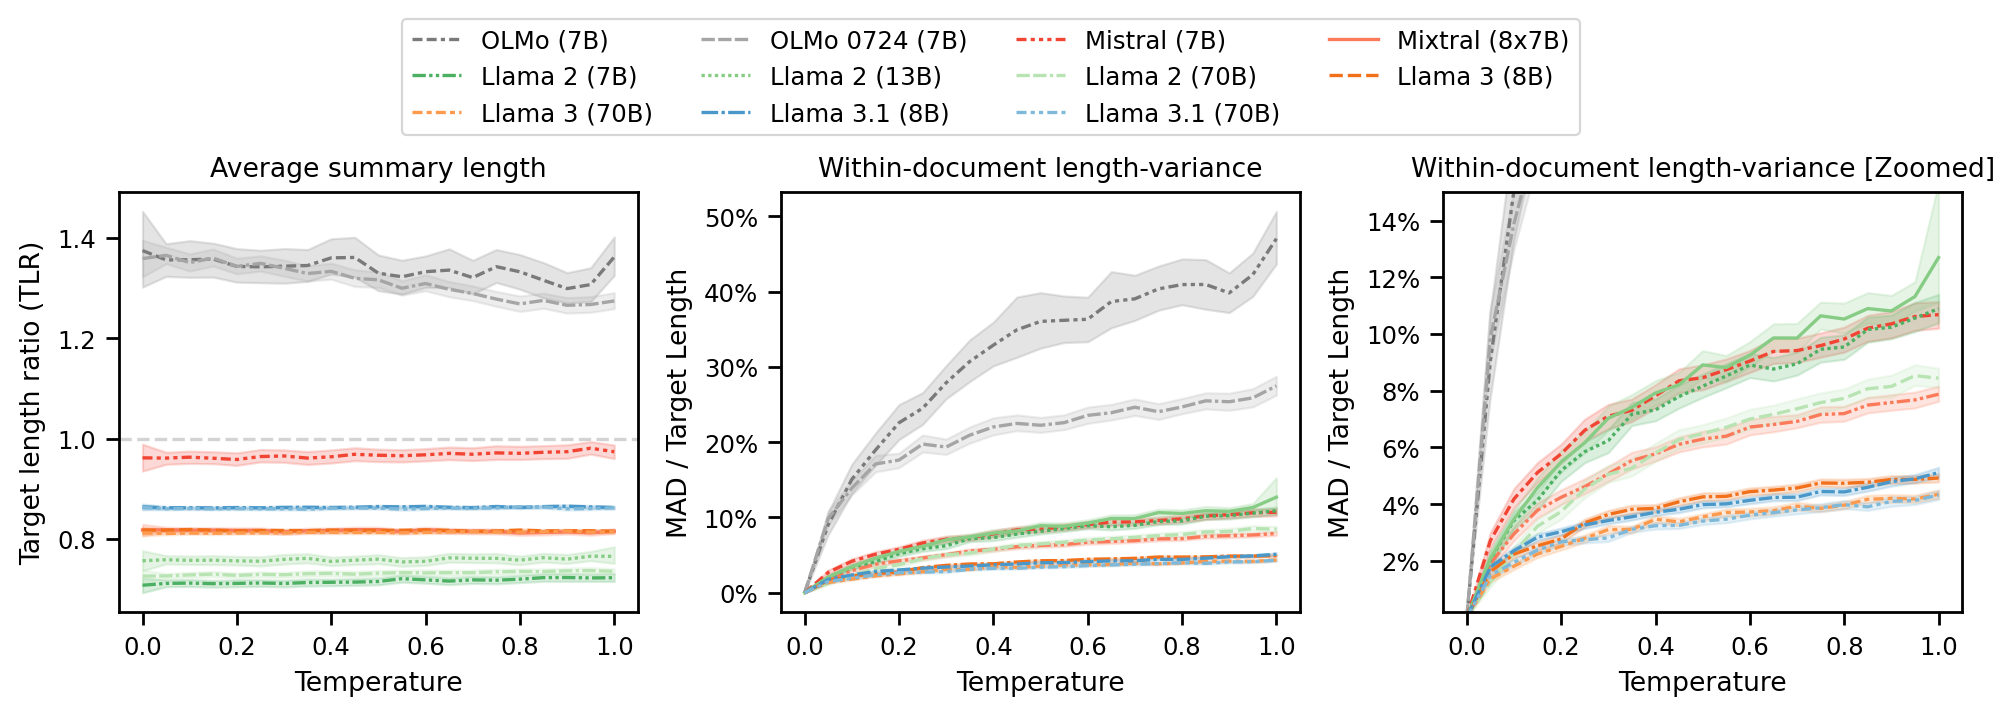

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

# Average length
sns.lineplot(
    df,
    x='temperature',
    y='deviation',
    hue='model',
    style='model',
    palette=color,
    hue_order=order,
    markers=False,
    dashes=True,
    # facet_kws={'legend_out': True},
    # height=4,
    ax=ax1,
)
ax1.axhline(1, 0, 1, linestyle='--', color='lightgray', zorder=0)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Target length ratio (TLR)')
ax1.set_title('Average summary length')

# Length variance
sns.lineplot(
    df_mad,
    x='temperature',
    y='mad_normalized',
    hue='model',
    style='model',
    palette=color,
    hue_order=order,
    markers=False,
    dashes=True,
    # facet_kws={'legend_out': True},
    # height=4,
    ax=ax2,
);
ax2.set_xlabel('Temperature')
ax2.set_ylabel('MAD / Target Length')
ax2.set_title('Within-document length-variance')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))


# Length variance
sns.lineplot(
    df_mad,
    x='temperature',
    y='mad_normalized',
    hue='model',
    style='model',
    palette=color,
    hue_order=order,
    markers=False,
    dashes=True,
    # facet_kws={'legend_out': True},
    # height=4,
    ax=ax3,
);
ax3.set_xlabel('Temperature')
ax3.set_ylabel('MAD / Target Length')
ax3.set_title('Within-document length-variance [Zoomed]')
ax3.set_ylim(0.002, 0.15)
ax3.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))


# Remove individual legends
ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()

def flip(items, ncol):
    """
    Flips the order of items in a list by grouping them into columns.
    *used to fill columns of legends first*

    Parameters:
        items (list): The list of items to be flipped.
        ncol (int): The number of columns to group the items into.

    Returns:
        itertools.chain: A chain object containing the flipped items.

    Source:
        https://stackoverflow.com/questions/10101141/matplotlib-legend-add-items-across-columns-instead-of-down
        https://github.com/matplotlib/matplotlib/issues/27067
    """
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])


ncol = 4
handles, labels = ax1.get_legend_handles_labels()

fig.legend(
    flip(handles, ncol),
    flip(labels, ncol),
    loc='upper center',
    ncol=4,  # Adjust number of columns if necessary
    bbox_to_anchor=(0.5, 1.2),
    frameon=True,
)

plt.tight_layout()
plt.show()

utils.savefig(fig, name='temperature-length', formats=['pdf'], path='../output/figures-paper/')